# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.

Most illustrative plots of how the pandemic is being controlled:
- [Relative increases per day by country](#country_relative_increases)
- [Relative increases per day by state](#us_state_relative_increases)

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Relative increases per day by country](#country_relative_increases)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [Density of infections per million people](#density_of_infections_by_country)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [State forecasts of infections/deaths 1 and 7 days in the future](#forecast_us_state)
- [States and their daily increase fraction in confirmed cases/deaths](#us_state_daily_increase_fraction)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)
- [Relative increases per day by state](#us_state_relative_increases)
- [When will each US state hit 1 case?](#us_state_0_new)

In [1]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [407]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt
import warnings

plt.rcParams['figure.figsize'] = 12,6
#plt.style.use('seaborn-dark-palette')
plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [408]:
# define paths to each raw file
d_ts = {}
#d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
#d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

#d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [409]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [410]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-05-13 21:11:29.865557
metric: deaths at 2020-05-13 21:11:32.410492
Latest data from 2020-05-13


In [411]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   #'recovered': np.sum,
               }))
#dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [412]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    #'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='deaths', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-13              US    1390406          21030   84119        1763   
1  2020-05-13  United Kingdom     230985           3244   33264         495   
2  2020-05-13           Italy     222104            888   31106         195   
3  2020-05-13           Spain     228691            661   27104         184   
4  2020-05-13          France     178184           -165   27077          83   
5  2020-05-13          Brazil     190137          11923   13240         779   
6  2020-05-13         Belgium      53981            202    8843          82   
7  2020-05-13         Germany     174098            927    7861         123   
8  2020-05-13            Iran     112725           1958    6783          50   
9  2020-05-13     Netherlands      43410            227    5581          52   
10 2020-05-13          Canada      73568           1149    5425         125   
11 2020-05-13           China      84024              6    4637           0   
12 2020-05-13          Mexico      40186           1862    4220         294   
13 2020-05-13          Turkey     143114           1639    3952          58   
14 2020-05-13          Sweden      27909            637    3460         147   
15 2020-05-13           India      78055           3763    2551         136   
16 2020-05-13         Ecuador      30486             67    2334           7   
17 2020-05-13          Russia     242271          10028    2212          96   
18 2020-05-13            Peru      76306           4247    2169         112   
19 2020-05-13     Switzerland      30413             33    1870           3   

    mortality_rate  
0         0.060500  
1         0.144009  
2         0.140052  
3         0.118518  
4         0.151961  
5         0.069634  
6         0.163817  
7         0.045153  
8         0.060173  
9         0.128565  
10        0.073741  
11        0.055187  
12        0.105012  
13        0.027614  
14        0.123974  
15        0.032682  
16        0.076560  
17        0.009130  
18        0.028425  
19        0.061487

<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [413]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

date         country  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-13              US    1390406          21030   84119        1763   
5  2020-05-13          Brazil     190137          11923   13240         779   
17 2020-05-13          Russia     242271          10028    2212          96   
18 2020-05-13            Peru      76306           4247    2169         112   
15 2020-05-13           India      78055           3763    2551         136   
1  2020-05-13  United Kingdom     230985           3244   33264         495   
36 2020-05-13           Chile      34381           2660     346          11   
8  2020-05-13            Iran     112725           1958    6783          50   
40 2020-05-13    Saudi Arabia      44830           1905     273           9   
12 2020-05-13          Mexico      40186           1862    4220         294   

    mortality_rate  
0         0.060500  
5         0.069634  
17        0.009130  
18        0.028425  
15        0.032682  
1         0.144009  
36        0.010064  
8         0.060173  
40        0.006090  
12        0.105012

<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

In [414]:
def plot_countries(
    dfp_country,
    countries=dfp_top_countries.iloc[:10]['country'],
    plot_cols=['confirmed', 'deaths', 'recovered', 'active', 'confirmed_new'],
    country_col='country',
    n_columns=2,
    y_min=1,
    y_max=dfp_top_countries['confirmed'].max() * 1.5,
    date_col='date',
    y_label='num_cases',
    date_min=datetime.datetime(2020,2,1),
    is_log=True,
):
    i = 1
    n_rows = int(np.ceil(len(countries) / n_columns))
    plt.figure(figsize=(12,n_rows*5))
    
    for country in countries:
        dfp_plot = dfp_country[(dfp_country[country_col] == country) &
                               (dfp_country[date_col] >= date_min)
                              ]
        dfp_plot = dfp_plot[dfp_plot['confirmed_new'] != 0]
        plt.subplot(n_rows, n_columns, i)
        for key in plot_cols:
            plt.plot(dfp_plot[date_col], dfp_plot[key], alpha=0.7, label=key)
        plt.legend(loc='best')
        plt.ylabel(f'{y_label}')
        plt.title(f'{country_col}: {country}')
        if is_log:
            plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()

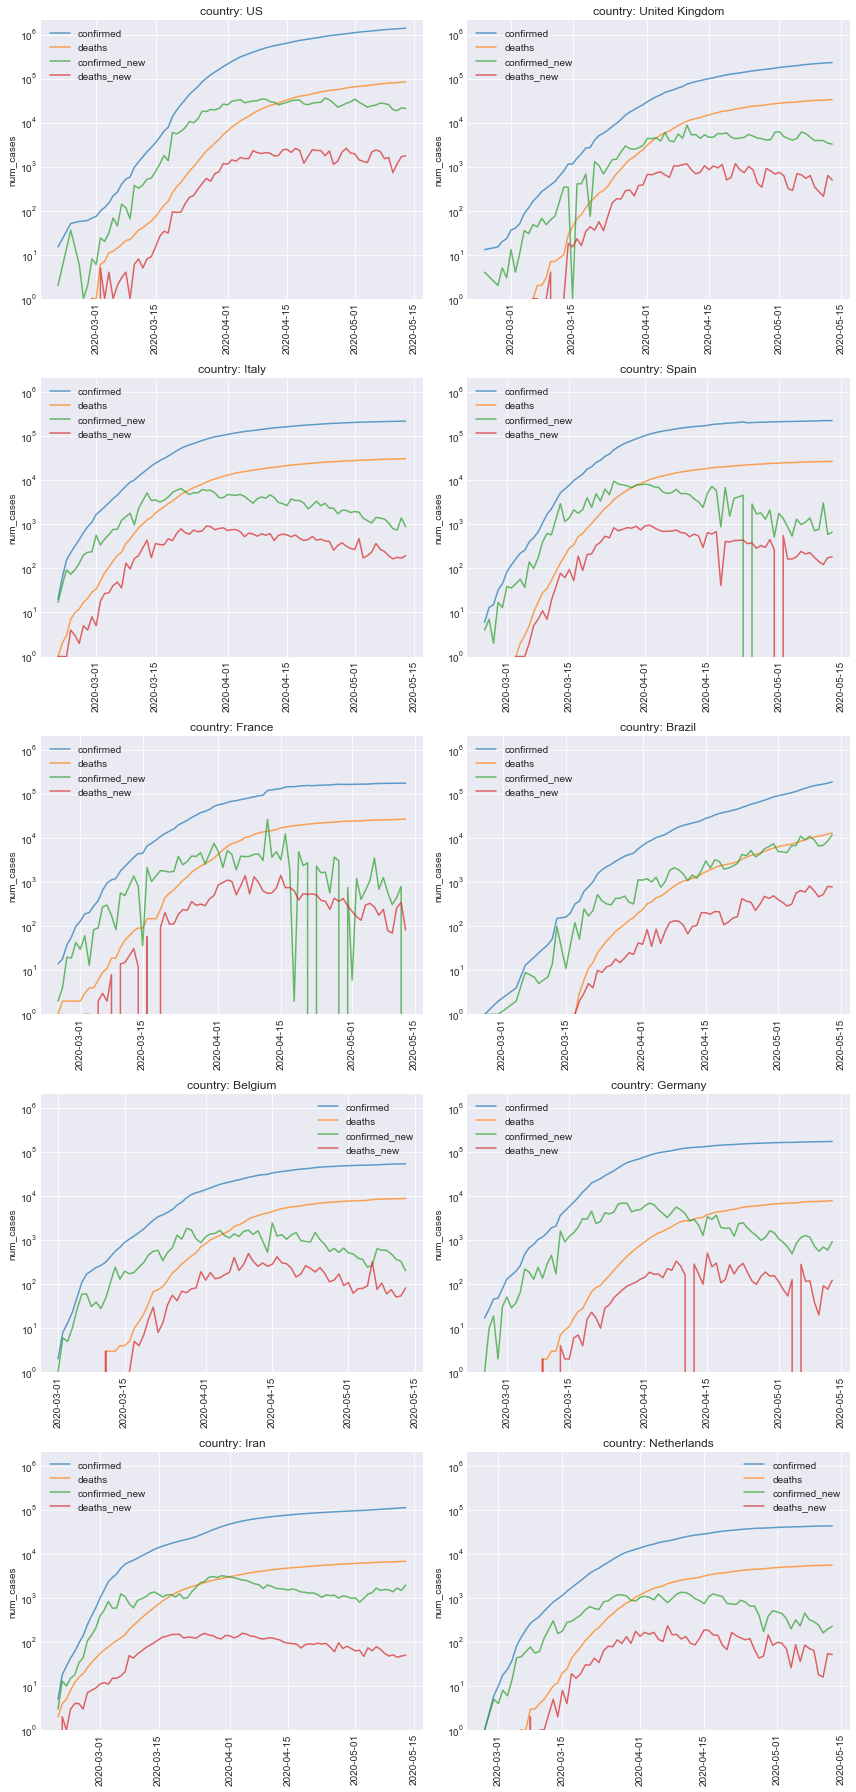

In [415]:
n_countries = 10

plot_countries(dfp_country, 
               countries=dfp_top_countries.iloc[:n_countries]['country'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

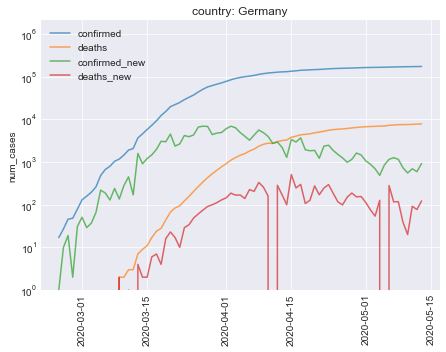

In [416]:
plot_countries(dfp_country, 
               countries=['Germany'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='country',
               date_min=datetime.datetime(2020,2,20),
              )

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

In [417]:
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, date_most_recent, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = date_most_recent + datetime.timedelta(days=days)  #dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['date'].apply(datetime_to_unixtime)
    #dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=None,
              col_locale='country'
             ):
    warnings.simplefilter('ignore', np.RankWarning)
    if date_most_recent is None:
        date_most_recent = dfp_country_recent['date'].max()
    dfp_country_recent = dfp_country_recent.set_index(col_locale)
    
    # fit
    dfp_country_recent_clean = dfp_country_recent[(dfp_country_recent['date'] <= date_most_recent) &
                                                  (dfp_country_recent[col_fit] > 0)
                                                 ]
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby([col_locale]).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'intercept']).reset_index() #'slope', 
    fit_col = col_fit.split('_')[0]
    dfp_country_recent[f"frac_increase_{fit_col}"] = (10**(dfp_country_recent['slope'] * 86400) - 1)
    #dfp_country_recent = dfp_country_recent.rename(columns={'slope': f'slope_{col_fit.split("_")[0]}'})
    return dfp_country_recent, dfp_country_confirmed_fit

def fit_exp(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False
           ):
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    #dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    #dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
    #dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0, sort=False)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                           col_fit='deaths_log', 
                                                           col_pred='deaths_pred', 
                                                           col_locale=col_locale, 
                                                           date_most_recent=date_most_recent
                                                          )
    dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, 
                                                              col_fit='confirmed_log', 
                                                              col_pred='confirmed_pred', 
                                                              col_locale=col_locale, 
                                                              date_most_recent=date_most_recent
                                                             )
    dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    dfp_forecasts_out = dfp_forecasts[['date', 
                                       col_locale, 
                                       'confirmed_pred', 
                                       'deaths_pred', 
                                       'mortality_rate_pred', 
                                       'frac_increase_confirmed', 
                                       'frac_increase_deaths'
                                      ]].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({'frac_increase_confirmed': np.mean, 
                              'frac_increase_deaths': np.mean}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=['confirmed_pred', 'deaths_pred', 'mortality_rate_pred']
                                                 ).sort_values(by=('deaths_pred', dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                  ):
    # subset the top countries
    dfp_non_pred = dfp_country_recent.dropna(subset=['deaths'])
    dt_max = dfp_non_pred['date'].max()
    dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                         sort_values(by='deaths', ascending=0).
                         iloc[:n_countries]
                        )
    top_countries = (dfp_top_countries.
                     iloc[:n_countries][col_locale].values
                    )

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    y_max = dfp_country_recent['confirmed_pred'].max()
    y_min = max(dfp_country_recent['deaths'].min(), 1)

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        plt.subplot(n_rows, n_columns, i)
        for key in ['confirmed', 'deaths']:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast(dfp_forecasts_out, dfp_country_recent, n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

##### Forecasts based on last 1 week

confirmed_pred                       deaths_pred             \
date               2020-05-14 2020-05-20 2020-06-03  2020-05-14 2020-05-20   
country                                                                      
US                  1416175.0  1562968.0  1967407.0     85266.0    94329.0   
United Kingdom       235822.0   261791.0   334055.0     33583.0    36179.0   
Italy                223151.0   229426.0   244762.0     31304.0    32469.0   
Spain                230375.0   238388.0   258187.0     27270.0    28302.0   
France               179145.0   182400.0   190228.0     27256.0    28405.0   
Brazil               199964.0   274590.0   575520.0     14014.0    19836.0   
Belgium               54652.0    57398.0    64353.0      8914.0     9342.0   
Germany              174803.0   179313.0   190294.0      7897.0     8347.0   
Iran                 114195.0   124629.0   152834.0      6834.0     7144.0   
Netherlands           43687.0    45135.0    48703.0      5620.0     5884.0   

                          mortality_rate_pred                        \
date           2020-06-03          2020-05-14 2020-05-20 2020-06-03   
country                                                               
US               119398.0            0.060209   0.060352   0.060688   
United Kingdom    43043.0            0.142408   0.138198   0.128850   
Italy             35359.0            0.140282   0.141523   0.144463   
Spain             30865.0            0.118372   0.118722   0.119545   
France            31278.0            0.152145   0.155729   0.164424   
Brazil            44622.0            0.070083   0.072239   0.077533   
Belgium           10423.0            0.163105   0.162758   0.161966   
Germany            9502.0            0.045177   0.046550   0.049933   
Iran               7921.0            0.059845   0.057322   0.051827   
Netherlands        6547.0            0.128642   0.130364   0.134427   

               frac_increase_confirmed frac_increase_deaths  
date                                                         
country                                                      
US                            0.016574             0.016977  
United Kingdom                0.017564             0.012486  
Italy                         0.004633             0.006109  
Spain                         0.005715             0.006211  
France                        0.003006             0.006905  
Brazil                        0.054279             0.059619  
Belgium                       0.008203             0.007851  
Germany                       0.004254             0.009296  
Iran                          0.014679             0.007408  
Netherlands                   0.005450             0.007657

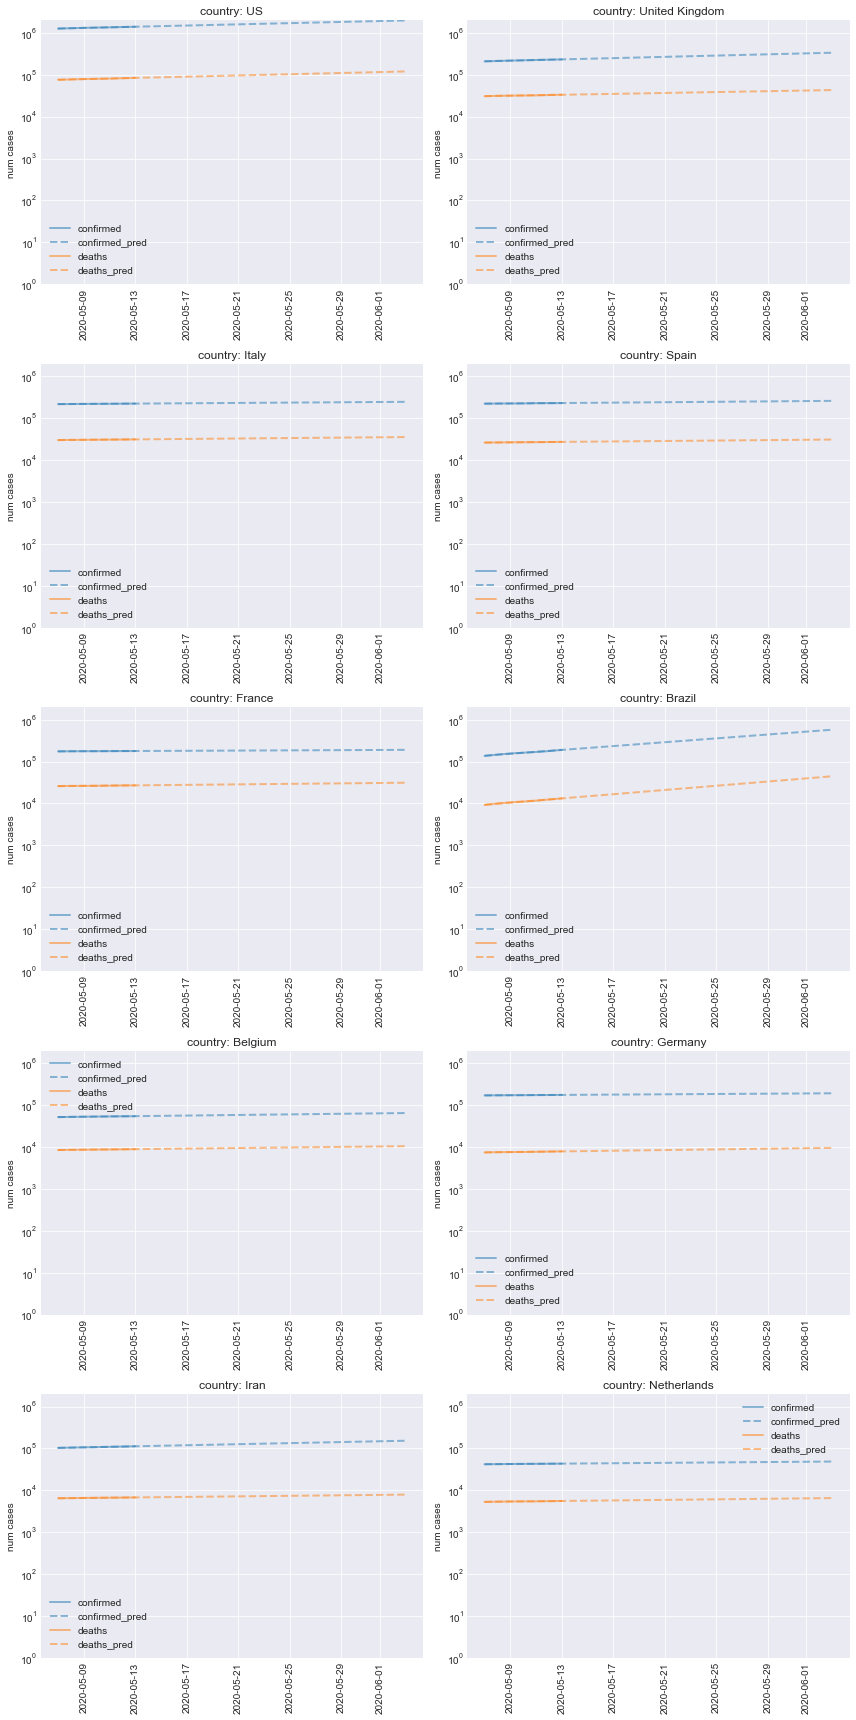

In [418]:
dfp_country_recent_1, dfp_forecasts_out_1 = fit_exp(dfp_country, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21], 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_1)

In [419]:
save_forecast(dfp_forecasts_out_1, dfp_country_recent_1, 7)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-13_n_days_training=7.csv


<a id='country_relative_increases'></a>
### Relative increases per day by country

In [420]:
def find_relative_increase_data_and_plot(dfp_us_g, 
                                         n_days_fit=7, 
                                         dt=datetime.datetime(2020,3,10),
                                         n_locales=7,
                                         col_locale='state'
                                        ):
    dt_max = dfp_us_g['date'].max()
    list_dfp_state_relative = []
    while dt <= dt_max:
        try:
            dfp_state_recent_tmp, dfp_state_forecasts_out_tmp = fit_exp(dfp_us_g, 
                                                                        n_days_predict=n_days_fit, 
                                                                        col_locale=col_locale, 
                                                                        top_countries=None,
                                                                        date_most_recent=dt,
                                                                        is_silent=True
                                                                       )
            dfp_state_recent_tmp = dfp_state_recent_tmp.dropna(subset=['confirmed'])
            dfp_state_recent_tmp_single = dfp_state_recent_tmp[dfp_state_recent_tmp['date'] == dfp_state_recent_tmp['date'].max()]
            list_dfp_state_relative.append(dfp_state_recent_tmp_single)
        except Exception as e:
            print(f"failed on {dt.strftime('%Y-%m-%d')}")

        dt += datetime.timedelta(days=1)
    dfp_state_relative_chng = pd.concat(list_dfp_state_relative)
                  
    # plot states
    top_states = (dfp_state_relative_chng[(dfp_state_relative_chng['date'] == dfp_state_relative_chng['date'].max())].
                  sort_values(by='deaths', ascending=0).
                  reset_index(drop=True).
                  iloc[:n_locales][col_locale].values
                 )
                  
    # deaths
    plt.subplot(1,2,1)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        #
        plt.plot(dfp_st['date'], dfp_st['frac_increase_deaths'], label=state, alpha=0.7)
        plt.ylabel('relative increase in deaths')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in deaths')

    # confirmed cases
    plt.subplot(1,2,2)
    for state in top_states:
        dfp_st = dfp_state_relative_chng[(dfp_state_relative_chng[col_locale] == state) & 
                                         (dfp_state_relative_chng['deaths'] > 2)]
        
        plt.plot(dfp_st['date'], dfp_st['frac_increase_confirmed'], label=state, alpha=0.7)
        plt.ylabel('relative increase in confirmed')
        plt.xticks(rotation=90)
        plt.legend(loc='best')
        plt.axhline(0, color='k', alpha=0.5)
        plt.title('Relative daily increase in confirmed')

    plt.show()
    return None


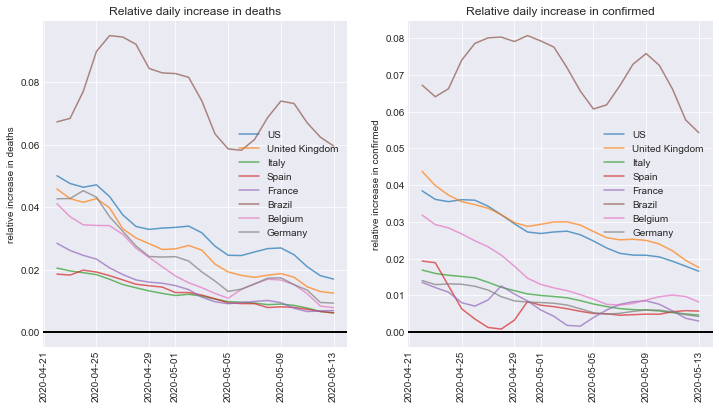

In [421]:
now = datetime.datetime.now()
now = datetime.datetime(now.year, now.month, now.day)
n_days_back = 21
dt_start = now - datetime.timedelta(days=n_days_back)
#dt_start = datetime.datetime(2020,3,2)
find_relative_increase_data_and_plot(dfp_country, n_locales=8, col_locale='country', dt=dt_start)

##### Forecasts based on last 2 weeks

confirmed_pred            deaths_pred             \
date               2020-05-14 2020-05-20  2020-05-14 2020-05-20   
country                                                           
US                  1435328.0  1617314.0     87008.0    99541.0   
United Kingdom       240415.0   275272.0     34046.0    37496.0   
Italy                224207.0   232162.0     31550.0    33131.0   
Spain                229961.0   237264.0     27438.0    28747.0   
France               180883.0   187266.0     27403.0    28794.0   
Brazil               206203.0   299435.0     14175.0    20583.0   
Belgium               54678.0    57525.0      9064.0     9773.0   
Germany              175310.0   180796.0      8011.0     8683.0   
Iran                 113717.0   123455.0      6882.0     7274.0   
Netherlands           43963.0    45883.0      5694.0     6083.0   

               mortality_rate_pred            frac_increase_confirmed  \
date                    2020-05-14 2020-05-20                           
country                                                                 
US                        0.060619   0.061547                0.020095   
United Kingdom            0.141613   0.136214                0.022822   
Italy                     0.140718   0.142706                0.005828   
Spain                     0.119316   0.121160                0.005225   
France                    0.151496   0.153760                0.005797   
Brazil                    0.068743   0.068739                0.064147   
Belgium                   0.165771   0.169891                0.008497   
Germany                   0.045696   0.048027                0.005149   
Iran                      0.060519   0.058920                0.013789   
Netherlands               0.129518   0.132576                0.007147   

               frac_increase_deaths  
date                                 
country                              
US                         0.022682  
United Kingdom             0.016216  
Italy                      0.008182  
Spain                      0.007798  
France                     0.008286  
Brazil                     0.064142  
Belgium                    0.012619  
Germany                    0.013508  
Iran                       0.009277  
Netherlands                0.011083

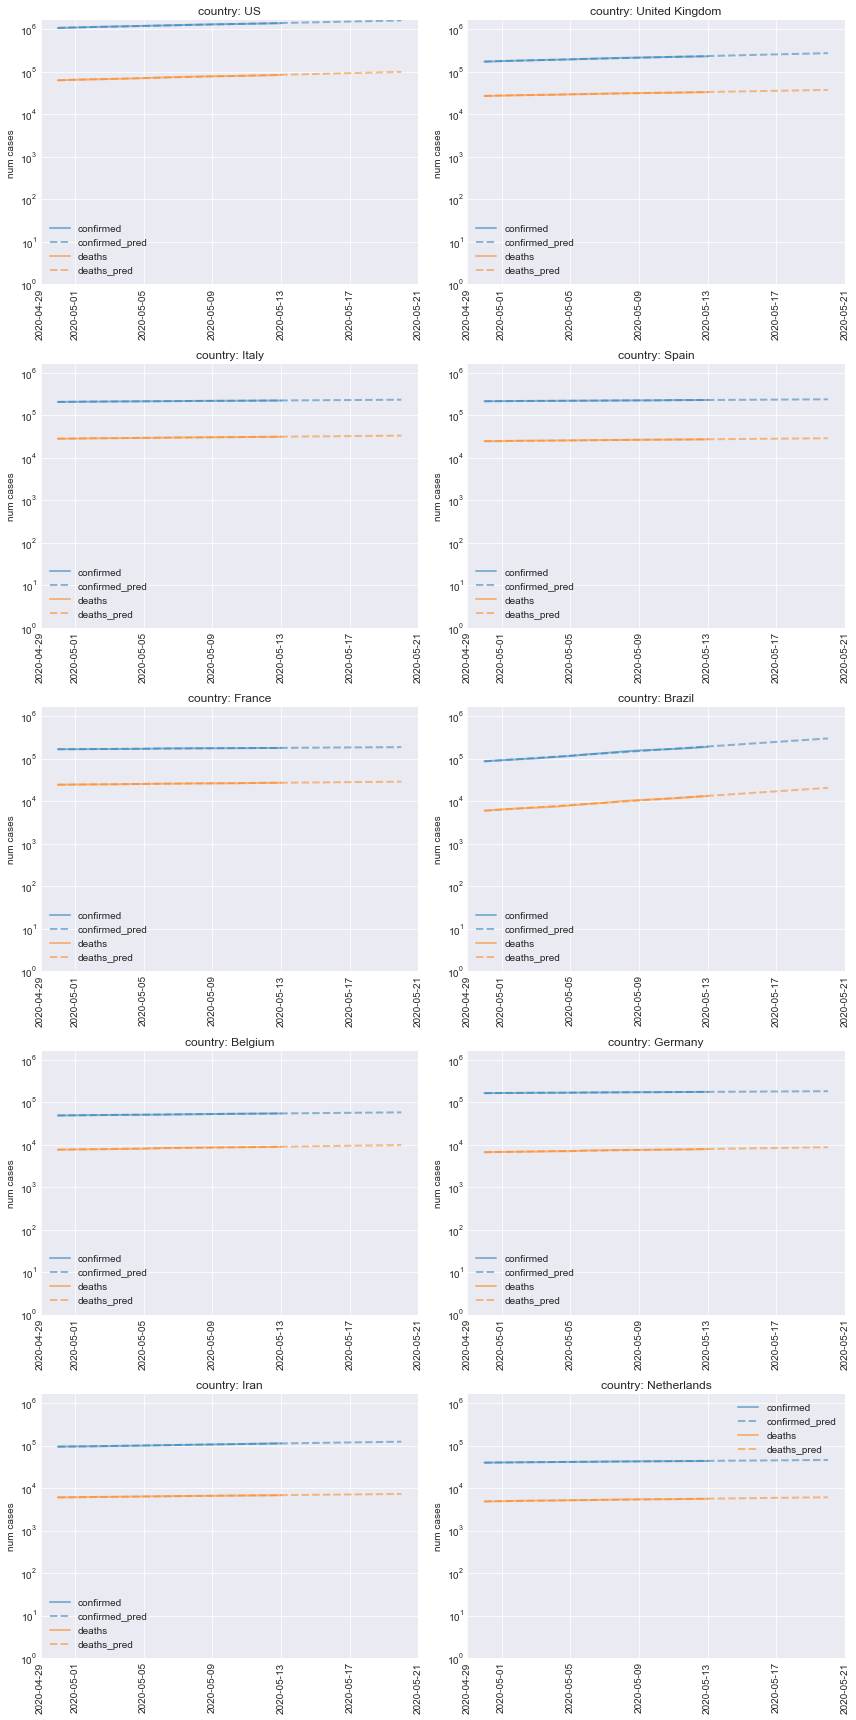

In [422]:
dfp_country_recent_2, dfp_forecasts_out_2 = fit_exp(dfp_country, 
                                                    n_days_predict=14, 
                                                    col_locale='country', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_country_recent_2)

In [423]:
save_forecast(dfp_forecasts_out_2, dfp_country_recent_2, 14)

saved forecast to predictions/covid-19_country_forecast_from_2020-05-13_n_days_training=14.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [424]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.4f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

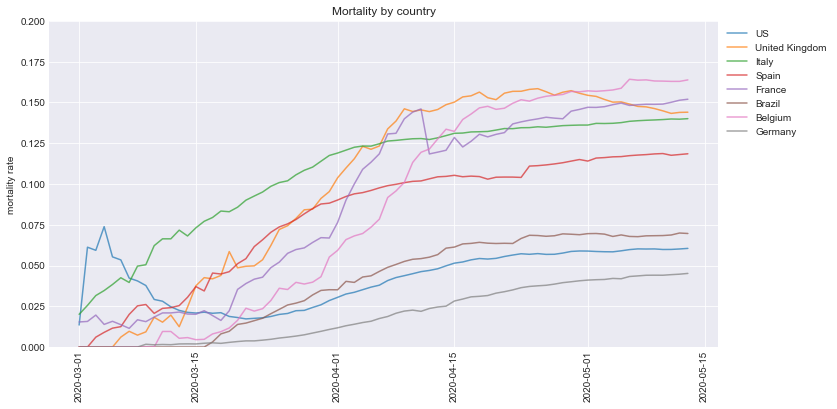

In [425]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [426]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    x_col='confirmed',
    y_col='mortality_rate'
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot[x_col], dfp_plot[y_col], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    #plt.xlabel('# confirmed cases')
    #plt.ylabel('mortality rate')
    plt.xlabel(x_col.replace('_', ' '))
    plt.ylabel(y_col.replace('_', ' '))
    plt.title(f'{y_col} vs {x_col} by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

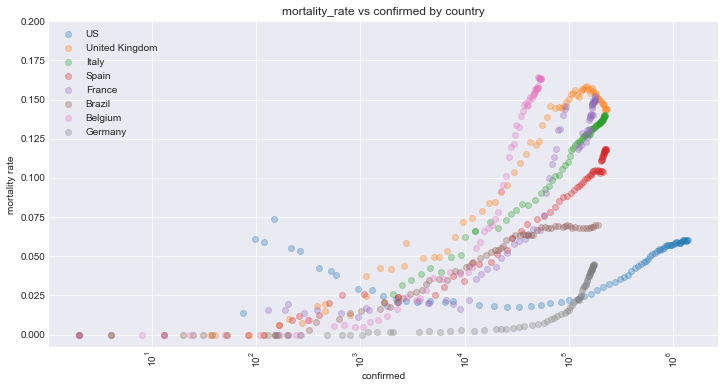

In [427]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [428]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

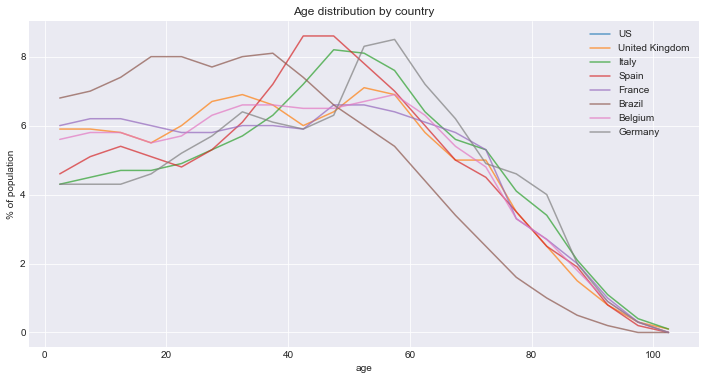

In [429]:
n_countries = 8
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

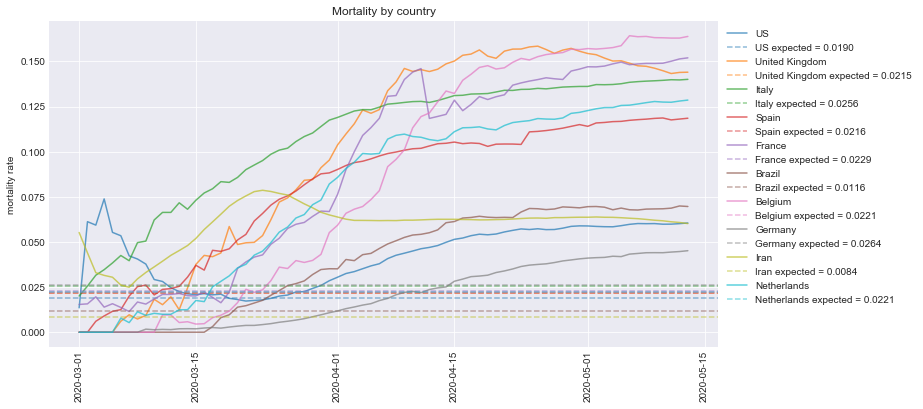

date         country  mortality_rate  confirmed   deaths
0 2020-05-13         Belgium        0.163817    53981.0   8843.0
1 2020-05-13          France        0.151961   178184.0  27077.0
2 2020-05-13  United Kingdom        0.144009   230985.0  33264.0
3 2020-05-13           Italy        0.140052   222104.0  31106.0
4 2020-05-13     Netherlands        0.128565    43410.0   5581.0
5 2020-05-13           Spain        0.118518   228691.0  27104.0
6 2020-05-13          Brazil        0.069634   190137.0  13240.0
7 2020-05-13              US        0.060500  1390406.0  84119.0
8 2020-05-13            Iran        0.060173   112725.0   6783.0
9 2020-05-13         Germany        0.045153   174098.0   7861.0

In [430]:
n_countries = 10
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)
dfp_display = (dfp_country[(dfp_country['date'] == dfp_country['date'].max()) & 
                           (dfp_country['country'].isin(countries))
                          ].
               sort_values(by='mortality_rate', ascending=0).
               reset_index(drop=True)
              )[['date', 'country', 'mortality_rate', 'confirmed', 'deaths']]
display(dfp_display)

**Remarks about the mortality rate being above the expected mortality rate**

Assuming the [cited report](https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/) of age-wise mortality is correct and that the virus is homogeneously distributed amongst the population, a discrepancy like this could arise if the country has:
- Preferentially tested people in critical condition, ignoring test for mild cases (perhaps if testing capacity is saturated)
- An overloaded hospital system, where patients are not receiving the same quality of care they would otherwise

If the testing is biased, we can estimate the true number of infections by multiplying the confirmed cases by the ratio between the measured mortality rate and the expected mortality rate.  For example, in Iran (as of 2020-03-22), we might estimate the true number of cases is 9.3x higher using this method (200,589 vs 21,638).

### Distribution of expected mortality fractions

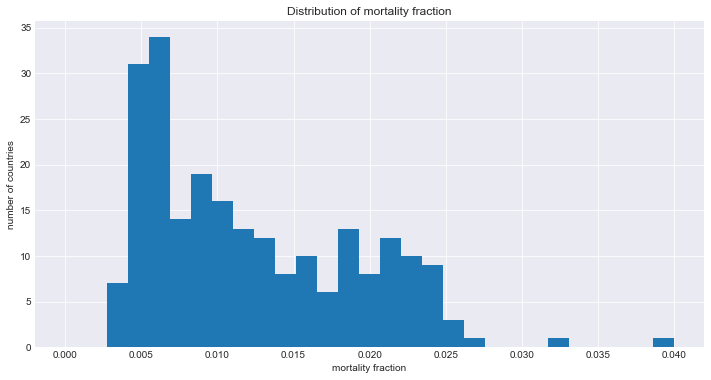

In [431]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [432]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

country  frac_mortality  num_deaths_max_expected        pop
1         Japan        0.031837              3998380.024  125507472
2       Germany        0.026398              2128411.026   80159662
3        Greece        0.025745               271233.247   10607051
4         Italy        0.025637              1599267.592   62402659
10     Portugal        0.023736               244829.259   10302674
18       France        0.022950              1564984.503   67848156
20       Sweden        0.022575               231555.716   10202491
23      Belgium        0.022146               259573.363   11720716
24  Netherlands        0.022076               382222.125   17280397
27       Canada        0.021712               820035.480   37694085

<a id='density_of_infections_by_country'></a>
# Density of infections per million people

In [433]:
# plot of country fractions that are infected
dfp_country_pop = dfp_country.merge(dfp_country_mortality_expected[['country', 'pop']], on='country', how='left').copy()
dfp_country_pop['deaths_per_million'] = dfp_country_pop['deaths'] / dfp_country_pop['pop'] * 1E6
dfp_country_pop['confirmed_per_million'] = dfp_country_pop['confirmed'] / dfp_country_pop['pop'] * 1E6

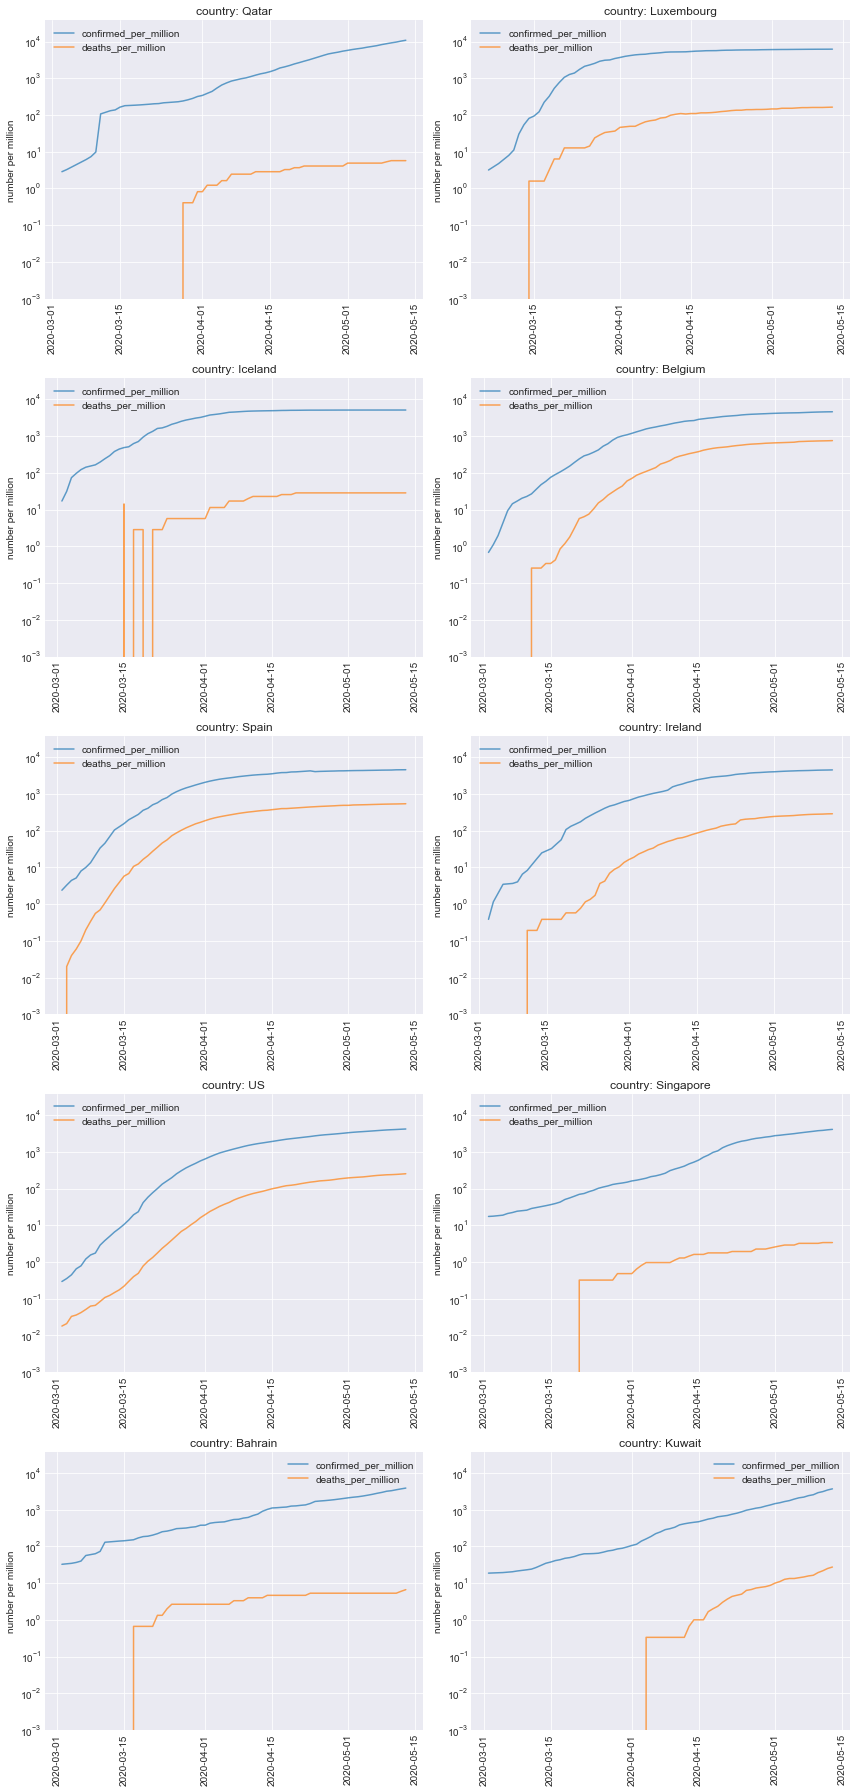

country   population  confirmed   deaths  confirmed_per_million  \
0       Qatar    2444174.0    26539.0     14.0           10858.064933   
1  Luxembourg     628381.0     3904.0    103.0            6212.791284   
2     Iceland     350734.0     1802.0     10.0            5137.796735   
3     Belgium   11720716.0    53981.0   8843.0            4605.606006   
4       Spain   50015792.0   228691.0  27104.0            4572.375861   
5     Ireland    5176569.0    23401.0   1497.0            4520.561785   
6          US  332639102.0  1390406.0  84119.0            4179.923502   
7   Singapore    6209660.0    25346.0     21.0            4081.704956   
8     Bahrain    1505003.0     5816.0     10.0            3864.444124   
9      Kuwait    2993706.0    11028.0     82.0            3683.728462   

   deaths_per_million  mortality_rate  
0            5.727906        0.000528  
1          163.913295        0.026383  
2           28.511636        0.005549  
3          754.476092        0.163817  
4          541.908844        0.118518  
5          289.187684        0.063972  
6          252.883679        0.060500  
7            3.381828        0.000829  
8            6.644505        0.001719  
9           27.390799        0.007436

In [434]:
n_countries = 10
dfp_country_pop_top = (dfp_country_pop[(dfp_country_pop['date'] == dfp_country_pop['date'].max()) &
                                       (dfp_country_pop['pop'] >= 1E5)
                                      ].
                       sort_values(by='confirmed_per_million', ascending=0).
                       reset_index(drop=True)
                      )

plot_countries(dfp_country_pop, 
               countries=dfp_country_pop_top.iloc[:n_countries]['country'],
               plot_cols=['confirmed_per_million', 'deaths_per_million'],
               country_col='country',
               y_max=dfp_country_pop['confirmed_per_million'].max()*2,
               y_min=0.001,
               y_label='number per million',
               date_min=datetime.datetime(2020,3,2)
              )
display_cols = ['country', 'pop', 'confirmed', 'deaths', 'confirmed_per_million', 'deaths_per_million', 'mortality_rate']
display(dfp_country_pop_top[display_cols].rename(columns={'pop': 'population'}).head(10))

### Mortality rate by deaths per capita, confirmed per capita

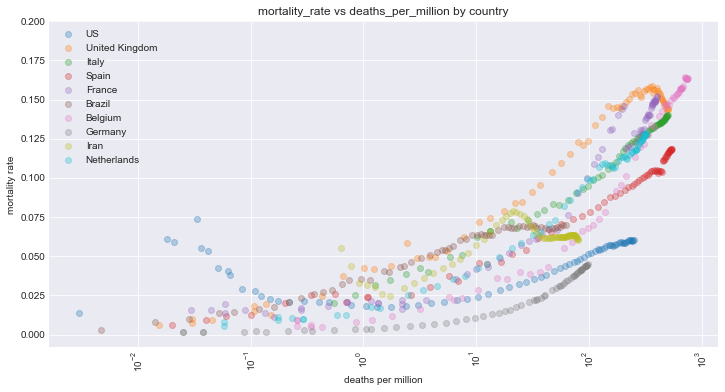

In [435]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='deaths_per_million', 
                                  y_col='mortality_rate'
                                 )

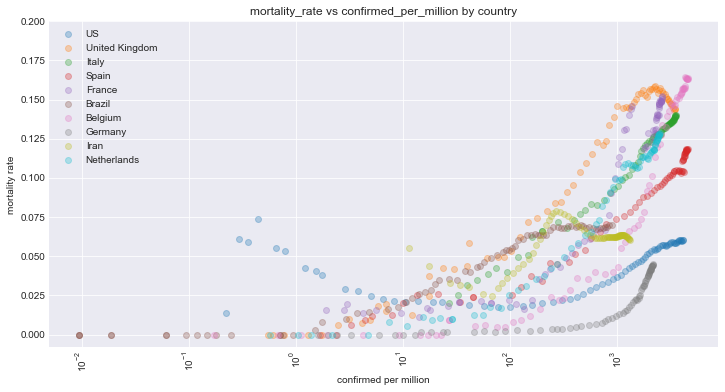

In [436]:
plot_mortality_rate_vs_infections(dfp_country_pop, 
                                  countries, 
                                  upper_lim=0.2, 
                                  id_col='country', 
                                  date_min=datetime.datetime(2020,3,1), 
                                  x_col='confirmed_per_million', 
                                  y_col='mortality_rate'
                                 )

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [437]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_pop, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

##### Days behind Italy via density of cases

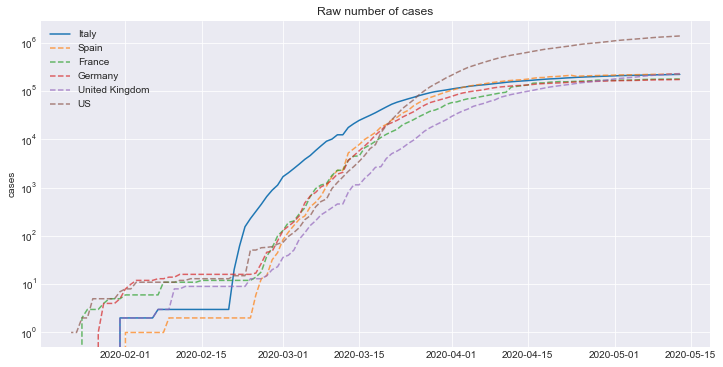

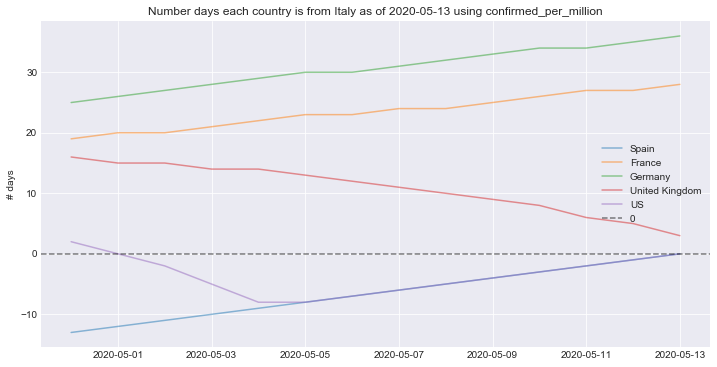

In [438]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed_per_million')

##### Days behind Italy via number of confirmed cases

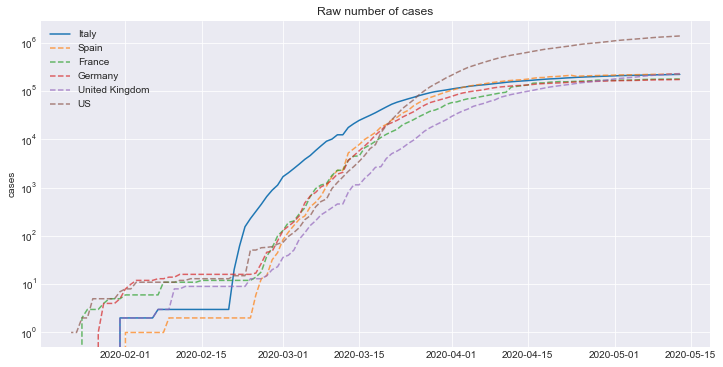

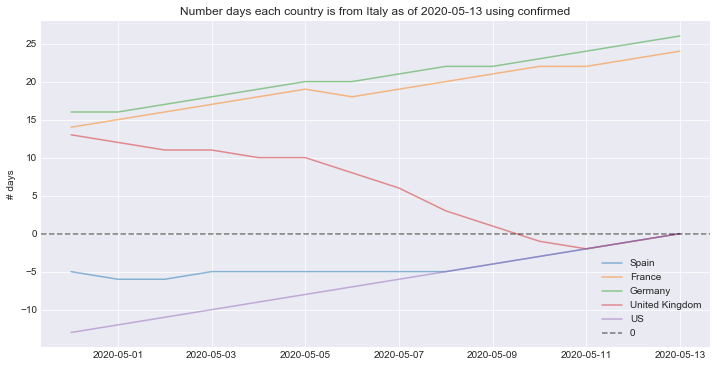

In [439]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', dfp=dfp_country_pop, compare_col='confirmed')

# US state breakdown

In [440]:
# load and clean data
dfp_us_raw = pd.read_csv('state_data/states-daily.csv')
dfp_us_raw = dfp_us_raw.rename(columns={'state': 'state_clean_1',
                                        'positive': 'confirmed',
                                        'death': 'deaths',
                                        'date': 'date_str'
                                       })
dfp_us_raw['date'] = dfp_us_raw['date_str'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
dfp_us_raw['country'] = 'US'

In [441]:
# load and clean data from CSSEGIS
state_base_dir = '../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/'
data_paths_raw = os.listdir(state_base_dir)
data_paths = [path for path in data_paths_raw if path.endswith('csv')]
list_dfp_states = []
cols_of_interest = ['country', 'state', 'date', 'confirmed', 'deaths', 'recovered']
for path in data_paths:
    full_path = os.path.join(state_base_dir, path)
    
    # read state data
    dfp_temp = pd.read_csv(full_path)
    cols = list(dfp_temp.columns)
    
    # clean column names
    cols_translate = {'Country/Region': 'country',
                      'Province/State': 'state',
                      'Confirmed': 'confirmed',
                      'Deaths': 'deaths',
                      'Recovered': 'recovered',
                      'Country_Region': 'country',
                      'Province_State': 'state',
                      'Last_Update': 'Last Update'
                     }
    dfp_temp = dfp_temp.rename(columns=cols_translate)
    dfp_temp['date'] = dfp_temp['Last Update'].apply(lambda x: parser.parse(x).date())
    dfp_temp['date'] = dfp_temp['date'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
    dfp_temp = dfp_temp[dfp_temp['country'] == 'US']
    list_dfp_states.append(dfp_temp[cols_of_interest])
dfp_us_raw = pd.concat(list_dfp_states)
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2}$)', x)[0].strip() if re.findall('\, ([A-Z]{2}$)', x) else x)

In [442]:
# look only at the US
#dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
#dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [443]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                #'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
#dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths_new'].fillna(0)
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [444]:
id_cols_state = ['date', 'state']
value_cols_state = ['confirmed', 'confirmed_new', 'deaths', 'deaths_new', 'mortality_rate']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols_state]
dfp_us_top_states = dfp_us_top_states.sort_values(by='deaths', ascending=0).reset_index(drop=True)
dfp_us_top_states = dfp_us_top_states.fillna(0)
for key in value_cols_state:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(15)

date          state  confirmed  confirmed_new  deaths  deaths_new  \
0  2020-05-14       New York     340661           2176   27477         193   
1  2020-05-14     New Jersey     141560            643    9714         183   
2  2020-05-14  Massachusetts      80497           1165    5315         174   
3  2020-05-14       Michigan      48391            370    4714          40   
4  2020-05-14   Pennsylvania      62101            791    4094         180   
5  2020-05-14       Illinois      84694           1673    3792         191   
6  2020-05-14    Connecticut      34855            522    3125          84   
7  2020-05-14     California      72798           1820    2957          78   
8  2020-05-14      Louisiana      32662            612    2381          34   
9  2020-05-14        Florida      42402            479    1827          48   
10 2020-05-14       Maryland      34812            751    1809          53   
11 2020-05-14        Indiana      25473            346    1619          41   
12 2020-05-14        Georgia      35427            503    1517          19   
13 2020-05-14           Ohio      25721            471    1483          47   
14 2020-05-14          Texas      43020           1588    1172          26   

    mortality_rate  
0         0.080658  
1         0.068621  
2         0.066027  
3         0.097415  
4         0.065925  
5         0.044773  
6         0.089657  
7         0.040619  
8         0.072898  
9         0.043088  
10        0.051965  
11        0.063557  
12        0.042820  
13        0.057657  
14        0.027243

<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [445]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

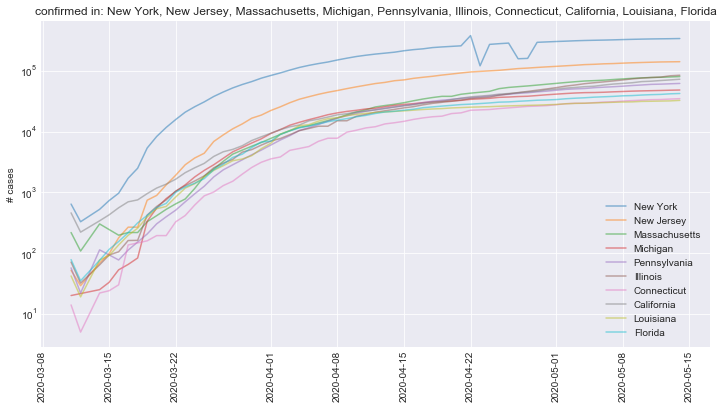

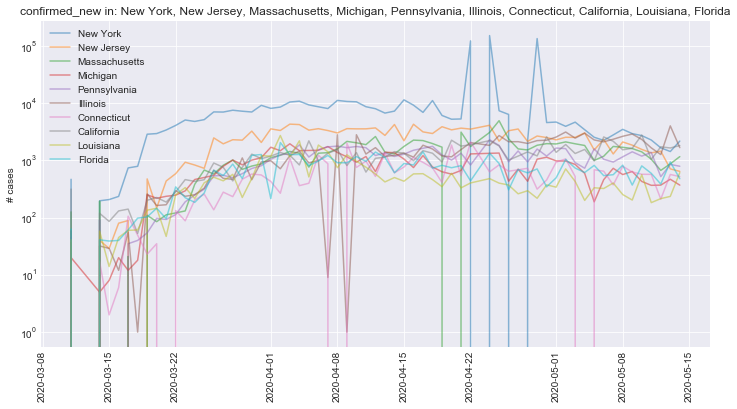

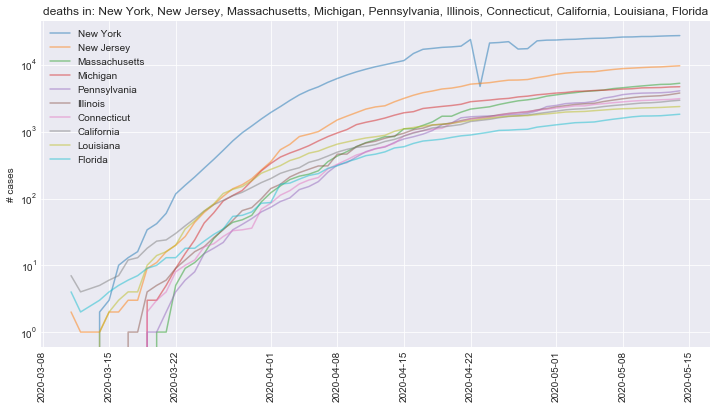

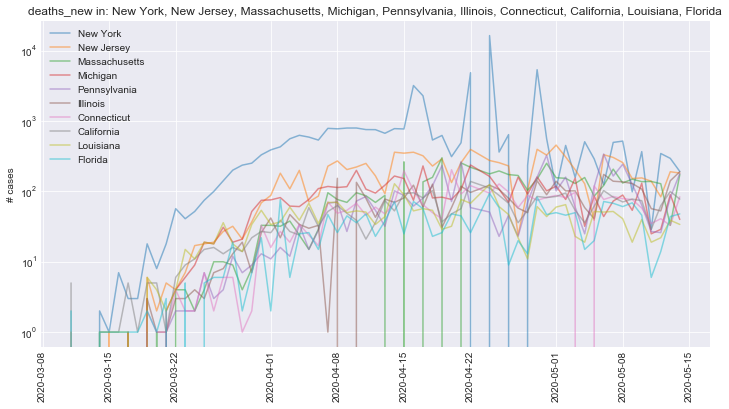

In [446]:
states_oi = dfp_us_top_states.iloc[:10]['state'].values
dt_min = datetime.datetime(2020,3,11)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths', date_min=dt_min)
plot_state_data(dfp_us_g, states_oi, plot_col='deaths_new', date_min=dt_min)

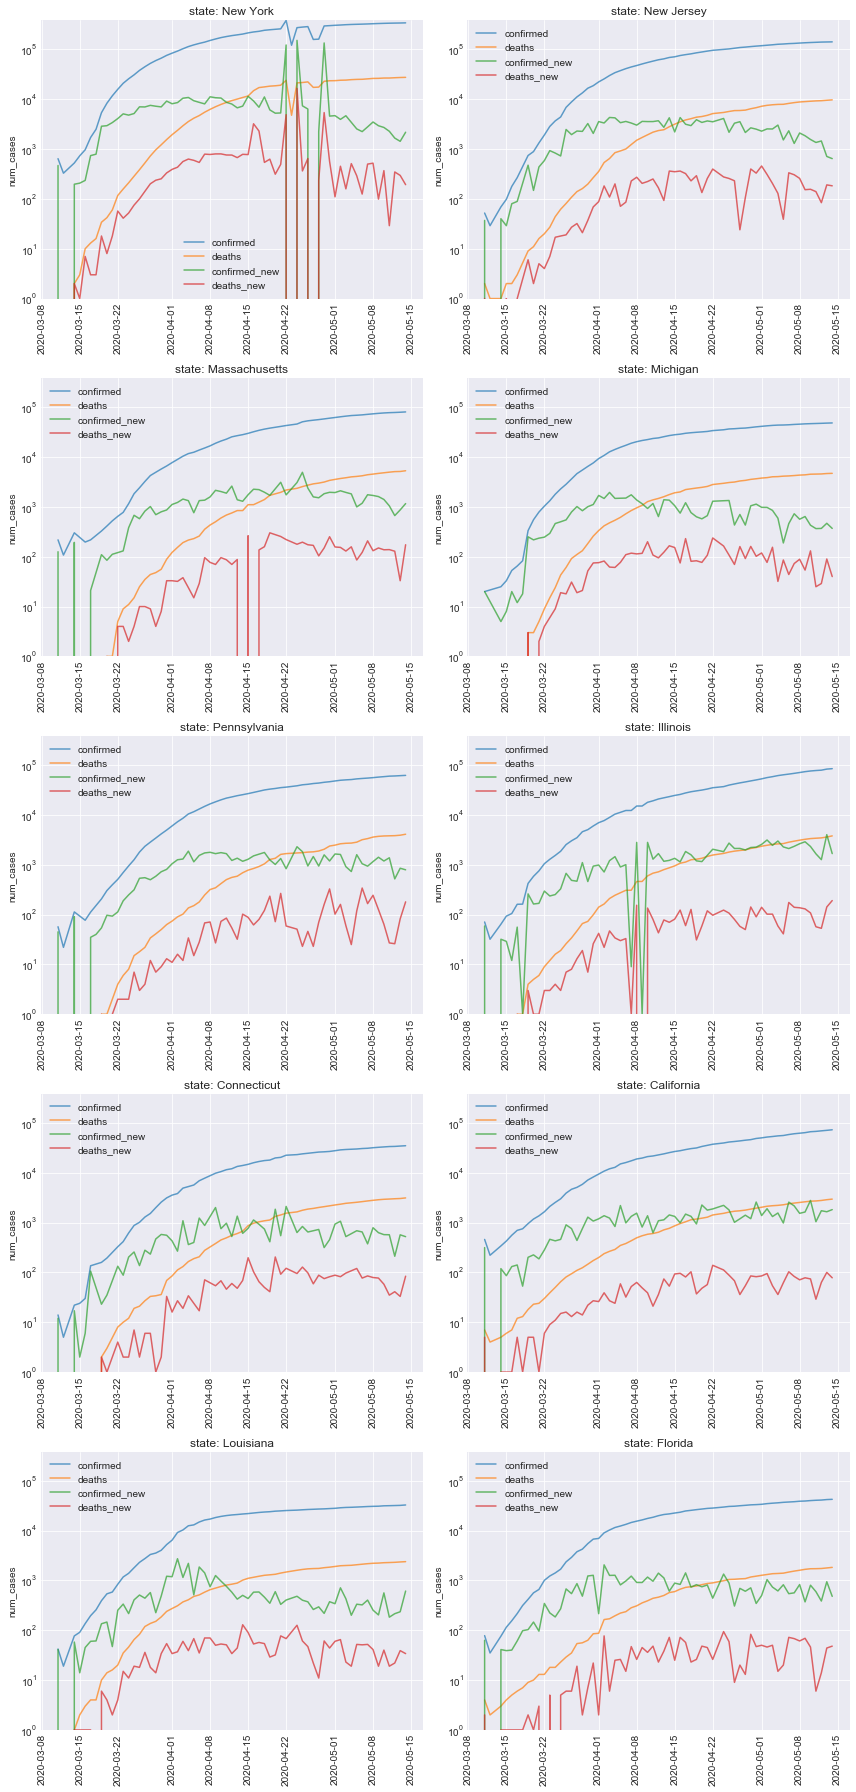

In [447]:
plot_countries(dfp_us_g, 
               countries=dfp_us_top_states.iloc[:10]['state'].values,
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

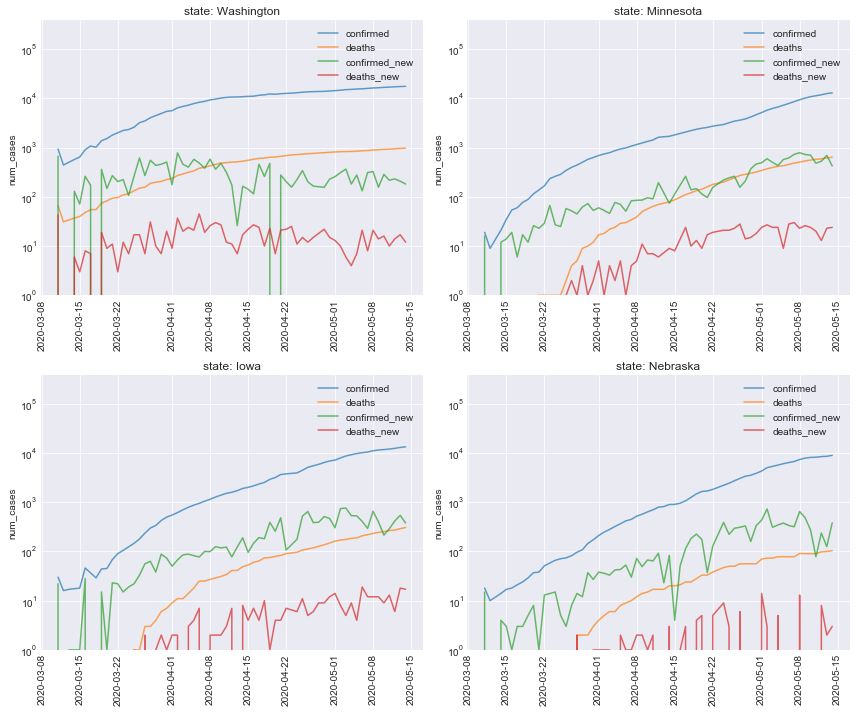

In [448]:
plot_countries(dfp_us_g, 
               countries=['Washington', 'Minnesota', 'Iowa', 'Nebraska'],
               plot_cols=['confirmed', 'deaths', 'confirmed_new', 'deaths_new'], #, 'recovered', 'active'
               country_col='state',
               date_min=datetime.datetime(2020,3,11),
               y_max=dfp_us_g['confirmed'].max()
              )

<a id='forecast_us_state'></a>
### Forecast by state

##### 1 week of data

confirmed_pred                       deaths_pred             \
date              2020-05-15 2020-05-21 2020-06-04  2020-05-15 2020-05-21   
state                                                                       
New York            343272.0   356659.0   389961.0     27703.0    29171.0   
New Jersey          143560.0   151736.0   172670.0      9843.0    10821.0   
Massachusetts        81807.0    88926.0   108040.0      5459.0     6339.0   
Michigan             48887.0    51617.0    58595.0      4793.0     5197.0   
Pennsylvania         63537.0    70380.0    89351.0      4105.0     4583.0   
Illinois             87274.0   103789.0   155517.0      3850.0     4606.0   
Connecticut          35408.0    38704.0    47637.0      3167.0     3504.0   
California           74917.0    87588.0   126121.0      3017.0     3498.0   
Louisiana            32856.0    34881.0    40106.0      2405.0     2592.0   
Florida              43066.0    47150.0    58248.0      1856.0     2083.0   

                         mortality_rate_pred                        \
date          2020-06-04          2020-05-15 2020-05-21 2020-06-04   
state                                                                
New York         32907.0            0.080703   0.081790   0.084385   
New Jersey       13497.0            0.068564   0.071315   0.078166   
Massachusetts     8984.0            0.066730   0.071284   0.083154   
Michigan          6277.0            0.098042   0.100684   0.107125   
Pennsylvania      5924.0            0.064608   0.065118   0.066300   
Illinois          6999.0            0.044114   0.044378   0.045005   
Connecticut       4435.0            0.089443   0.090533   0.093100   
California        4938.0            0.040271   0.039937   0.039153   
Louisiana         3086.0            0.073198   0.074310   0.076946   
Florida           2725.0            0.043097   0.044178   0.046783   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.006396             0.008645  
New Jersey                   0.009274             0.015907  
Massachusetts                0.014004             0.025217  
Michigan                     0.009098             0.013579  
Pennsylvania                 0.017193             0.018499  
Illinois                     0.029307             0.030338  
Connecticut                  0.014943             0.016971  
California                   0.026385             0.024931  
Louisiana                    0.010019             0.012549  
Florida                      0.015213             0.019373

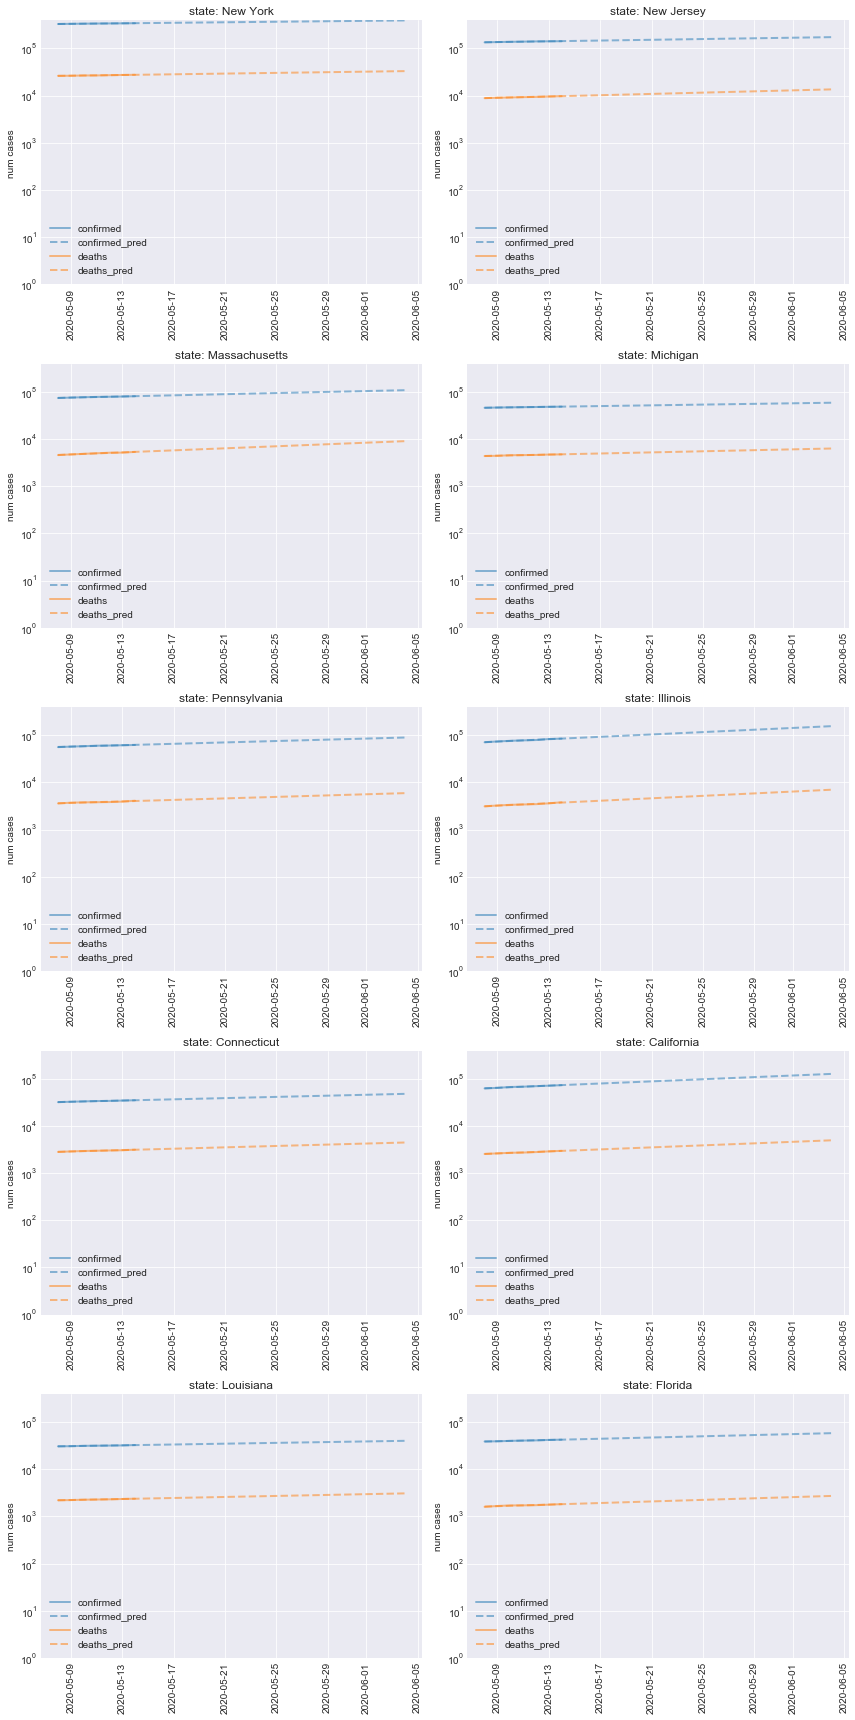

In [449]:
dfp_state_recent_1, dfp_state_forecasts_out_1 = fit_exp(dfp_us_g, 
                                                    n_days_predict=7,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_1, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

##### 2 weeks of data

confirmed_pred                       deaths_pred             \
date              2020-05-15 2020-05-21 2020-06-04  2020-05-15 2020-05-21   
state                                                                       
New York            346159.0   364327.0   410512.0     28027.0    30076.0   
New Jersey          146093.0   158521.0   191788.0     10088.0    11546.0   
Massachusetts        83582.0    93955.0   123444.0      5583.0     6720.0   
Michigan             49360.0    52899.0    62173.0      4851.0     5358.0   
Pennsylvania         64266.0    72497.0    96039.0      4446.0     5666.0   
Illinois             89536.0   110622.0   181196.0      3937.0     4897.0   
Connecticut          35703.0    39592.0    50394.0      3267.0     3796.0   
California           75761.0    90215.0   135591.0      3061.0     3631.0   
Louisiana            32981.0    35182.0    40908.0      2446.0     2707.0   
Florida              43419.0    48093.0    61048.0      1921.0     2287.0   

                         mortality_rate_pred                        \
date          2020-06-04          2020-05-15 2020-05-21 2020-06-04   
state                                                                
New York         35458.0            0.080966   0.082552   0.086375   
New Jersey       15820.0            0.069052   0.072836   0.082487   
Massachusetts    10356.0            0.066797   0.071524   0.083892   
Michigan          6759.0            0.098278   0.101287   0.108713   
Pennsylvania      9977.0            0.069181   0.078155   0.103885   
Illinois          8150.0            0.043971   0.044268   0.044979   
Connecticut       5386.0            0.091505   0.095878   0.106878   
California        5411.0            0.040403   0.040248   0.039907   
Louisiana         3429.0            0.074164   0.076943   0.083822   
Florida           3437.0            0.044243   0.047554   0.056300   

              frac_increase_confirmed frac_increase_deaths  
date                                                        
state                                                       
New York                     0.008562             0.011828  
New Jersey                   0.013700             0.022751  
Massachusetts                0.019689             0.031371  
Michigan                     0.011606             0.016726  
Pennsylvania                 0.020289             0.041232  
Illinois                     0.035876             0.037050  
Connecticut                  0.017381             0.025312  
California                   0.029531             0.028895  
Louisiana                    0.010828             0.017028  
Florida                      0.017183             0.029510

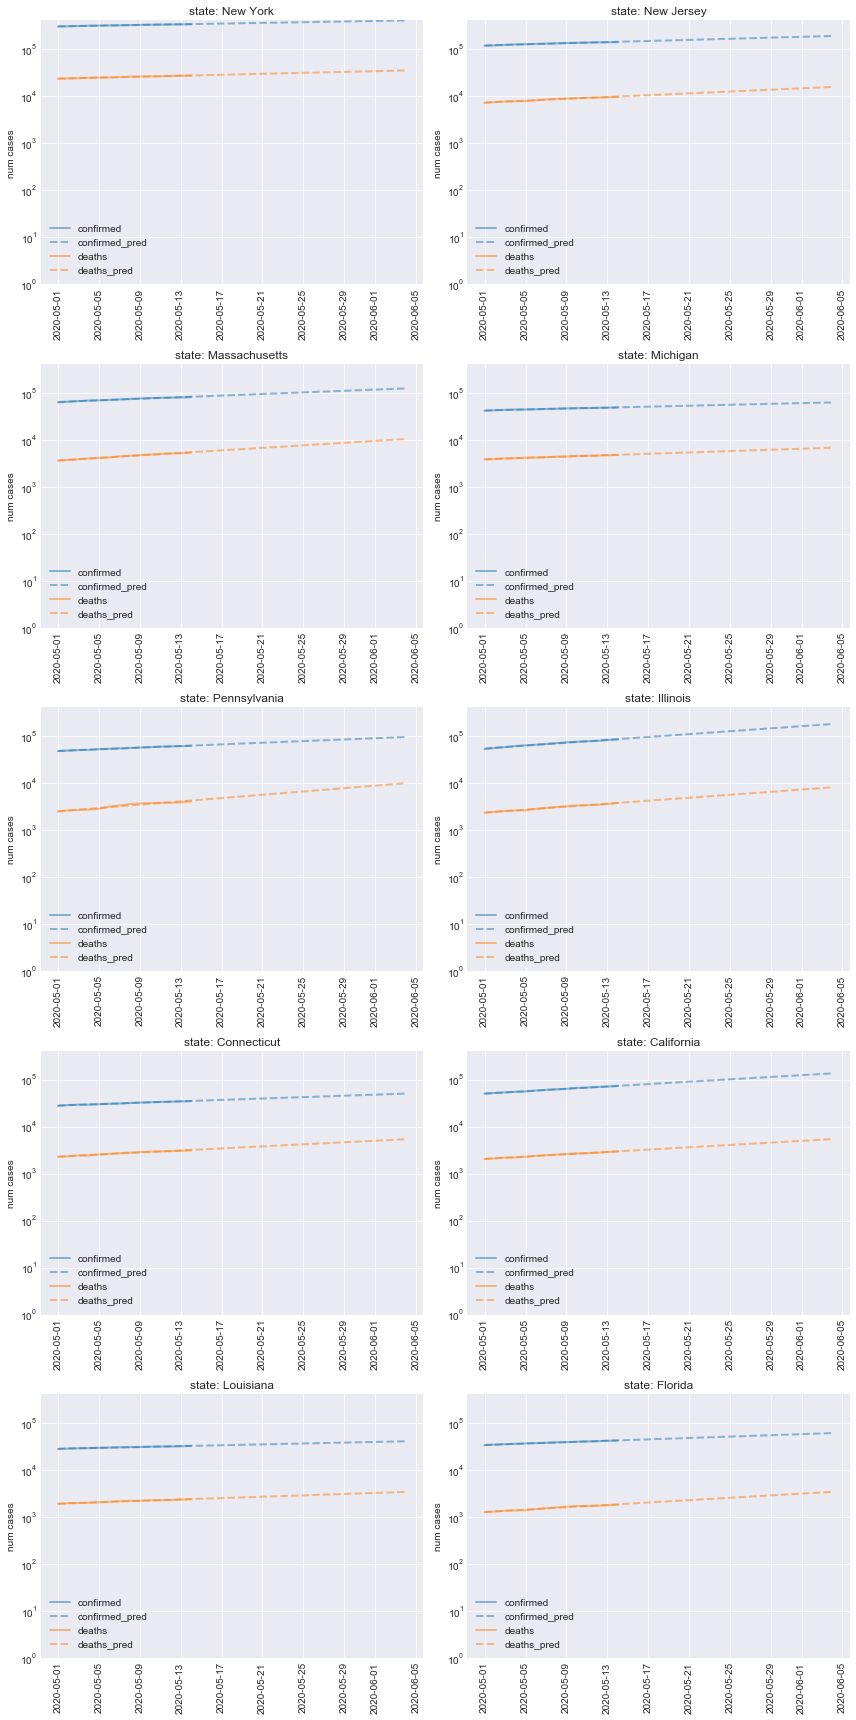

In [450]:
dfp_state_recent_2, dfp_state_forecasts_out_2 = fit_exp(dfp_us_g, 
                                                    n_days_predict=14,
                                                    n_days_into_future=[1,7,21],
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )
plot_forecasts(dfp_state_recent_2, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='state',
                  )

<a id='us_state_daily_increase_fraction'></a>
##### States and their daily increase fraction in confirmed cases/deaths
Computed via linear fit of the log of the confirmed cases/deaths over the last 7 days.

In [451]:
# increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
# curr_cols = ['date', 'state', 'confirmed', 'deaths']
# dfp_state_increase_m = dfp_us_g_latest[curr_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
# for col in ['confirmed', 'deaths']:
#     dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)

In [452]:
# latest date
dt_latest = dfp_us_g['date'].max()
dfp_us_g_date_max = dfp_us_g.groupby(['state'], as_index=False).agg({'date': np.max})
#dfp_us_g_latest = dfp_us_g[dfp_us_g['date'] == dt_latest].copy()
dfp_us_g_latest = dfp_us_g.merge(dfp_us_g_date_max, on=['state', 'date'], how='inner')

# what is the distribution in % increase in deaths?
dfp_state_increase = (dfp_state_forecasts_out_1[(dfp_state_forecasts_out_1['date'] == dfp_state_forecasts_out_1['date'].max()) &
                                                (dfp_state_forecasts_out_1['deaths_pred'] > 2)
                                               ].
                      sort_values(by='frac_increase_deaths', ascending=0).
                      reset_index(drop=True)
                     )
increase_cols = ['state', 'frac_increase_confirmed', 'frac_increase_deaths']
curr_cols = ['date', 'state']
int_cols = ['confirmed', 'deaths', 'deaths_new']
float_cols = ['frac_increase_confirmed', 'frac_increase_deaths']
dfp_state_increase_m = dfp_us_g_latest[curr_cols + int_cols].merge(dfp_state_increase[increase_cols], on=['state'], how='inner')
for col in int_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(int)
for col in float_cols:
    dfp_state_increase_m[col] = dfp_state_increase_m[col].apply(lambda x: np.round(float(x),3))
(dfp_state_increase_m[curr_cols + int_cols + float_cols].
 sort_values(by='frac_increase_deaths', ascending=0).
 reset_index(drop=True)
)


date                 state  confirmed  deaths  deaths_new  \
0  2020-05-14        Virgin Islands         69       6           0   
1  2020-05-14            New Mexico       5364     231          12   
2  2020-05-14                  Iowa      13289     306          17   
3  2020-05-14          South Dakota       3732      39           0   
4  2020-05-14         New Hampshire       3299     150           8   
5  2020-05-14          North Dakota       1647      40           2   
6  2020-05-14             Minnesota      12917     638          24   
7  2020-05-14               Arizona      12216     595          33   
8  2020-05-14                  Utah       6620      75           2   
9  2020-05-14        North Carolina      16352     625          25   
10 2020-05-14  District of Columbia       6584     350          14   
11 2020-05-14               Alabama      10700     450          15   
12 2020-05-14              Delaware       6952     247          10   
13 2020-05-14              Missouri      10404     551          22   
14 2020-05-14              Maryland      34812    1809          53   
15 2020-05-14              Illinois      84694    3792         191   
16 2020-05-14                 Texas      43020    1172          26   
17 2020-05-14          Rhode Island      11835     462          18   
18 2020-05-14              Virginia      26746     928          36   
19 2020-05-14           Mississippi      10090     465           8   
20 2020-05-14         Massachusetts      80497    5315         174   
21 2020-05-14            California      72798    2957          78   
22 2020-05-14                  Ohio      25721    1483          47   
23 2020-05-14        South Carolina       8030     362           7   
24 2020-05-14              Nebraska       8912     103           3   
25 2020-05-14             Tennessee      16370     273           7   
26 2020-05-14         West Virginia       1398      58           0   
27 2020-05-14                Kansas       7518     188           4   
28 2020-05-14               Indiana      25473    1619          41   
29 2020-05-14             Wisconsin      10902     421           3   
30 2020-05-14              Arkansas       4236      97           2   
31 2020-05-14           Puerto Rico       2329     115           1   
32 2020-05-14               Florida      42402    1827          48   
33 2020-05-14          Pennsylvania      62101    4094         180   
34 2020-05-14               Georgia      35427    1517          19   
35 2020-05-14                Nevada       6476     331          10   
36 2020-05-14              Colorado      20475    1062          52   
37 2020-05-14           Connecticut      34855    3125          84   
38 2020-05-14            New Jersey     141560    9714         183   
39 2020-05-14              Kentucky       6853     321           0   
40 2020-05-14                Oregon       3416     134           4   
41 2020-05-14            Washington      17512     974          12   
42 2020-05-14              Michigan      48391    4714          40   
43 2020-05-14             Louisiana      32662    2381          34   
44 2020-05-14              Oklahoma       4858     278           0   
45 2020-05-14                 Maine       1515      66           1   
46 2020-05-14              New York     340661   27477         193   
47 2020-05-14                 Idaho       2293      69           0   
48 2020-05-14                  Guam        152       5           0   
49 2020-05-14                Alaska        383      10           0   
50 2020-05-14                Hawaii        638      17           0   
51 2020-05-14               Montana        462      16           0   
52 2020-05-14               Vermont        929      53           0   
53 2020-05-14               Wyoming        688       7           0   

    frac_increase_confirmed  frac_increase_deaths  
0                     0.006                 0.084  
1                     0.029                 0.049  
2 

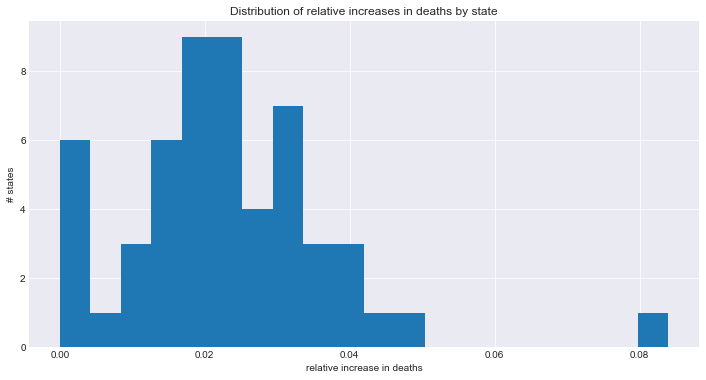

In [453]:
dfp_state_increase_m['frac_increase_deaths'].hist(bins=20)
plt.xlabel('relative increase in deaths')
plt.ylabel('# states')
plt.title('Distribution of relative increases in deaths by state')
plt.show()

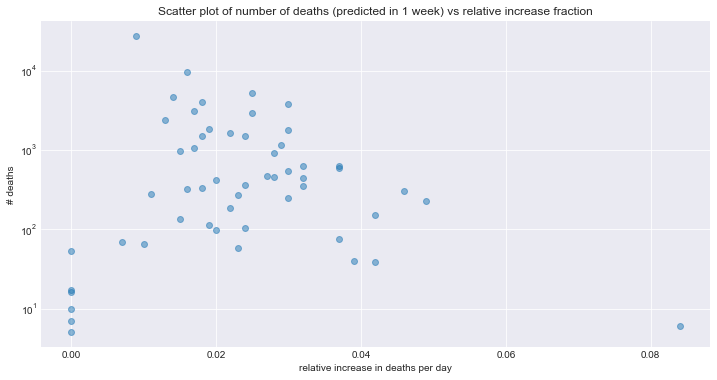

In [454]:
plt.plot(dfp_state_increase_m['frac_increase_deaths'], dfp_state_increase_m['deaths'], 'o', alpha=0.5)
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('relative increase in deaths per day')
plt.ylabel('# deaths')
plt.title('Scatter plot of number of deaths (predicted in 1 week) vs relative increase fraction')
plt.show()

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

In [455]:
dfp_us_g = dfp_us_g[~(dfp_us_g['date']==datetime.datetime(2020,3,9))]

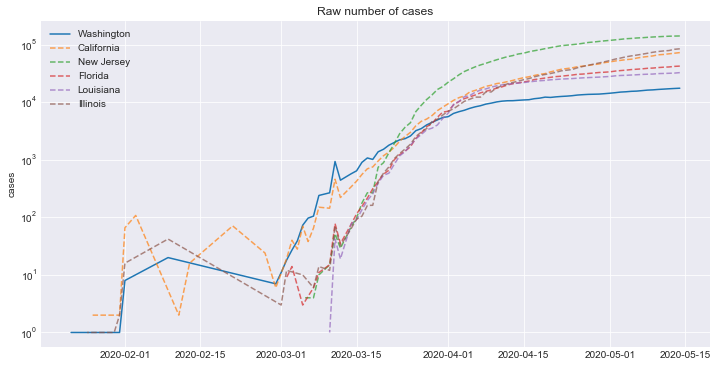

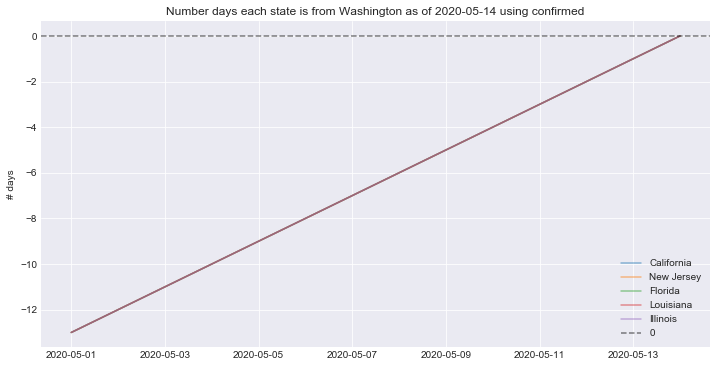

In [456]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

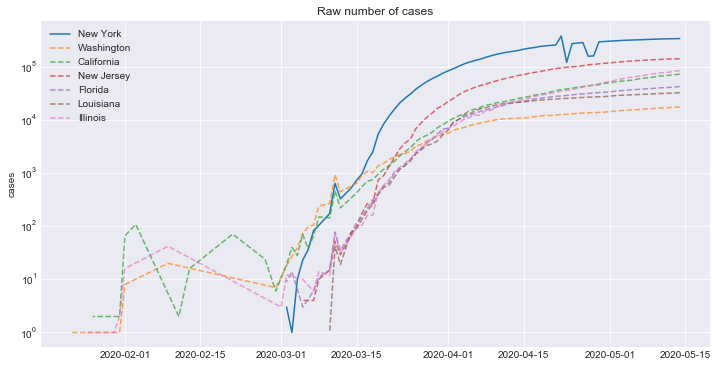

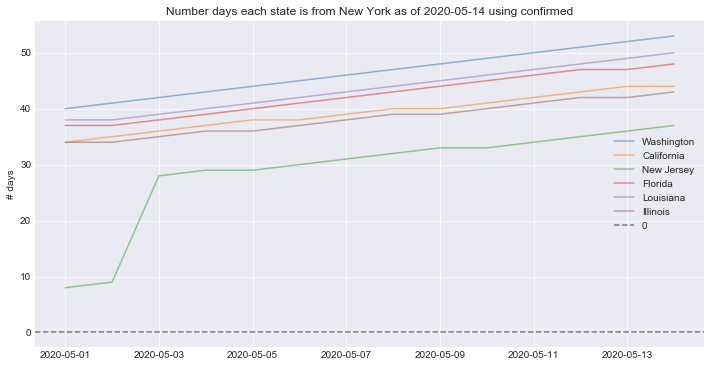

In [457]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

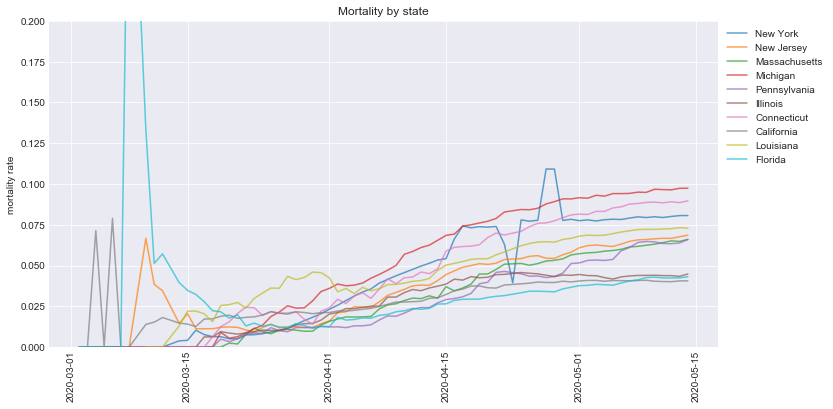

In [458]:
n_states = 10
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,2))

##### Relationship between mortality rate and number of cases

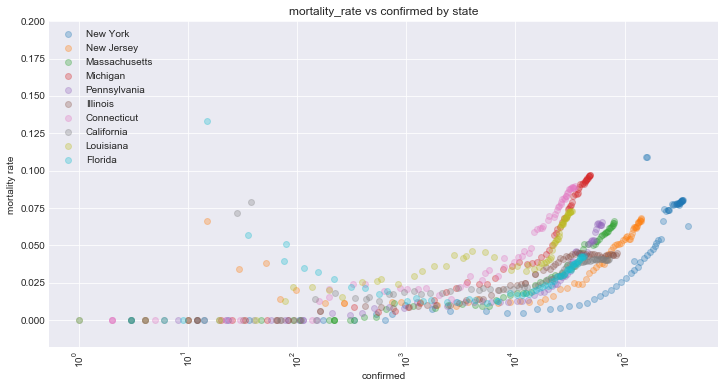

In [459]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

<a id='us_state_relative_increases'></a>
### Relative increases per day by state

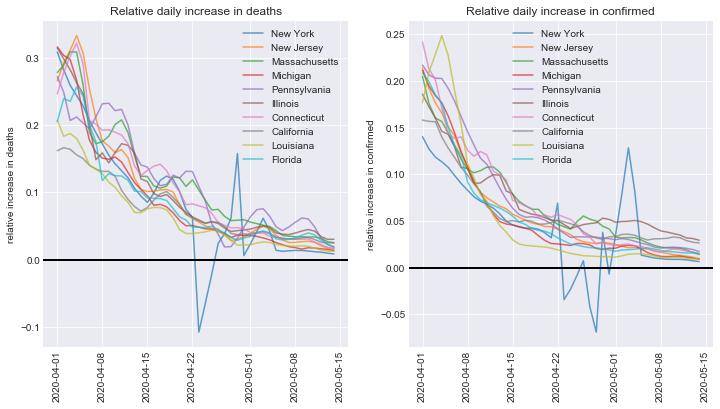

In [460]:
find_relative_increase_data_and_plot(dfp_us_g, n_locales=10, col_locale='state', dt=datetime.datetime(2020,4,1))


<a id='us_state_0_new'></a>
# When will each state hit 0 new deaths/confirmed? 

In [461]:
def fit_exp_new(dfp_country, 
            n_days_predict=14, 
            n_days_into_future=[1,7],
            col_locale='country', 
            top_countries=None, 
            n_countries=10, 
            date_most_recent=None,
            is_silent=False,
            fit_cols=['confirmed_new', 'deaths_new']
           ):
    
    # make predictions based on the last 2 weeks of data
    if date_most_recent is None:
        date_most_recent = dfp_country['date'].max()
    date_n_days_ago = date_most_recent - datetime.timedelta(days=n_days_predict-1)
    dfp_country_recent = (dfp_country[dfp_country['date'].between(date_n_days_ago, date_most_recent)].
                          sort_values(by=[col_locale, 'date'])
                         ).copy()

    # clean data for fit (convert to log)
    median_funcs = {}
    log_cols = []
    for col in fit_cols:
        log_col = f'{col}_log'
        dfp_country_recent[log_col] = dfp_country_recent[col].apply(lambda x: np.log10(x) if x > 1 else None)
        median_funcs[log_col] = np.nanmedian
        log_cols.append(log_col)
    dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
    
    # fill in the missing data with the median
    dfp_country_medians = dfp_country_recent.groupby(col_locale, as_index=False).agg(median_funcs).fillna(0)
    null_countries = list(dfp_country_recent[dfp_country_recent.isnull().any(axis=1)][col_locale].unique())
#     print(f"{col_locale}s with nulls: {','.join(null_countries)}")
#     display(dfp_country_medians.sample(n=5))
#     print(log_cols)
    for col in log_cols:
        for country in null_countries:
            val = dfp_country_medians[dfp_country_medians[col_locale] == country][col].values[0]
            #print(f"country={country}, median value={val:0.5f}")
            dfp_country_recent.loc[(dfp_country_recent[col_locale] == country) & (dfp_country_recent[col].isnull()), col] = val
    
    
    # make predictions to past, then future
    # add in future points
    dfp_country_recent_max_date = dfp_country_recent.groupby([col_locale], as_index=False).agg({'date': np.max})
    dfp_most_recent = dfp_country_recent.merge(dfp_country_recent_max_date, on=[col_locale, 'date'], how='inner').copy()
    list_dfp_recent = [dfp_country_recent]
    for n in n_days_into_future:
        dfp_most_recent_tmp = shift_future(dfp_most_recent, date_most_recent, n)
        list_dfp_recent.append(dfp_most_recent_tmp)
    dfp_country_recent = pd.concat(list_dfp_recent, axis=0, sort=False)
    
    for col in fit_cols:
        dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, 
                                                               col_fit=f'{col}_log', 
                                                               col_pred=f'{col}_pred', 
                                                               col_locale=col_locale, 
                                                               date_most_recent=date_most_recent
                                                              )
    #dfp_country_recent['mortality_rate_pred'] = dfp_country_recent['deaths_pred'] / dfp_country_recent['confirmed_pred']

    # look only at the predictions for top countries
    if top_countries is None:
        top_countries = (dfp_most_recent.
                         sort_values(by='deaths', ascending=0).iloc[:n_countries][col_locale].values)
    dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent)
                                       
                                      ].sort_values(by=[col_locale, 'date']).reset_index(drop=True)
    frac_cols = [col for col in dfp_forecasts.columns if 'frac_increase' in col]
    pred_cols = [col for col in dfp_forecasts.columns if '_pred' in col]
    id_cols = ['date', col_locale]
    dfp_forecasts_out = dfp_forecasts[id_cols + pred_cols + frac_cols].copy()
    dfp_forecasts_out['date'] = dfp_forecasts_out['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

    # find the daily fractional increase in cases
    dfp_frac_increase = (dfp_forecasts_out.
                         groupby([col_locale]).
                         agg({x: np.mean for x in frac_cols}))
    dfp_frac_increase.columns = pd.MultiIndex.from_product([dfp_frac_increase.columns, ['']])

    # pivot so each date of prediction has its own column
    dfp_forecasts_print = dfp_forecasts_out.pivot(index=col_locale, 
                                                  columns='date', 
                                                  values=pred_cols  #'mortality_rate_pred'
                                                 ).sort_values(by=(pred_cols[0], dfp_forecasts_out['date'].min()), ascending=0)
    dfp_forecasts_print = dfp_forecasts_print.merge(dfp_frac_increase, on=col_locale, how='inner')
    if not is_silent:
        display(dfp_forecasts_print[dfp_forecasts_print.index.isin(top_countries)])
    return dfp_country_recent, dfp_forecasts_out


def plot_forecasts_new(dfp_country_recent, 
                   n_countries=10, 
                   n_columns=2, 
                   figsize=(12,24), 
                   date_min=datetime.datetime(2020, 2, 1),
                   col_locale='country',
                       top_countries=None,
                       cols_to_pred=['confirmed_new', 'deaths_new'],
                  ):
    # subset the top countries
    death_cols = [col for col in cols_to_pred if 'deaths' in col]
    dfp_non_pred = dfp_country_recent.dropna(subset=[death_cols[0]])
    dt_max = dfp_non_pred['date'].max()
    
    if top_countries is None:
        dfp_top_countries = (dfp_non_pred[dfp_non_pred['date'] == dt_max].
                             sort_values(by=death_cols[0], ascending=0).
                             iloc[:n_countries]
                            )
        top_countries = (dfp_top_countries.
                         iloc[:n_countries][col_locale].values
                        )
    dfp_country_recent = dfp_country_recent[dfp_country_recent[col_locale].isin(top_countries)]

    # plot the top countries
    i = 1
    n_rows = int(np.ceil(n_countries / n_columns))
    plt.figure(figsize=figsize)
    
    y_max = 1
    pred_cols = [x + '_pred' for x in cols_to_pred]
    for col in cols_to_pred:
        y_max = max(dfp_country_recent[col].max(), y_max)
    y_min = 1

    for country in top_countries:
        dfp_plot = dfp_country_recent[(dfp_country_recent[col_locale] == country) &
                               (dfp_country_recent['date'] >= date_min)
                              ].sort_values(by='date')
        
        # find total deaths
        dfp_plot_calcs = dfp_plot.dropna(subset={'deaths_new'})
        dfp_plot_latest = dfp_plot_calcs[dfp_plot_calcs['date'] == dfp_plot_calcs['date'].max()]
        x = 1 + dfp_plot_calcs['frac_increase_deaths'].mean()
        n_days = (dfp_country_recent['date'].max() - dfp_plot_calcs['date'].max()).days
        multiplier = (x**n_days - 1) / (x - 1)
        curr_deaths_new = dfp_plot_latest['deaths_new_pred'].values[0]
        curr_deaths_total = dfp_plot_latest['deaths'].values[0]
        n_deaths_pred = curr_deaths_new * multiplier + curr_deaths_total
        
        
        plt.subplot(n_rows, n_columns, i)
        for key in cols_to_pred:
            p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
            pred_col = f'{key}_pred'
            plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
        plt.legend(loc='best')
        plt.ylabel('num cases')
        plt.title(f'{col_locale}: {country}, pred_tot_deaths = {n_deaths_pred:0.0f}, curr_deaths = {curr_deaths_total:0.0f}, x={x:0.3f}')
        plt.yscale('log')
        plt.ylim([y_min, y_max])
        plt.xticks(rotation=90)

        i += 1
    plt.tight_layout()
    plt.show()
    return None
                       
                       
def save_forecast_new(dfp_forecasts_out, dfp_country_recent, col_locale='state', n_days_training=14):
    date_most_recent = dfp_country_recent.dropna(subset=['deaths'])['date'].max()
    dfp_forecasts_out['date_of_forecast'] = date_most_recent
    save_name = f"new_cases_covid-19_{col_locale}_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}_n_days_training={n_days_training}.csv"
    save_path = os.path.join('predictions', save_name)
    dfp_forecasts_out.to_csv(save_path, index=False)
    print(f'saved forecast to {save_path}')
    return None

In [462]:
n_days_training = 21
dfp_us_recent_1, dfp_forecasts_us_out_1 = fit_exp_new(dfp_us_g, 
                                                    n_days_predict=n_days_training,
                                                    n_days_into_future=[1,7,2*7,4*7,8*7,12*7,16*7,20*7,24*7,32*7], 
                                                    col_locale='state', 
                                                    top_countries=None
                                                   )

confirmed_new_pred                                              \
date                  2020-05-15 2020-05-21 2020-05-28 2020-06-11 2020-07-09   
state                                                                          
Illinois                    2244       2218       2188       2130       2018   
California                  1752       1833       1932       2147       2652   
New York                    1192        579        249         46          1   
New Jersey                   986        674        432        178         30   
Massachusetts                887        638        435        201         43   
Pennsylvania                 829        688        553        357        149   
Florida                      560        527        491        426        320   
Connecticut                  473        421        368        281        163   
Michigan                     358        267        190         96         24   
Louisiana                    289        270        250        213        156   

                                                                      \
date          2020-08-06 2020-09-03 2020-10-01 2020-10-29 2020-12-24   
state                                                                  
Illinois            1911       1811       1715       1625       1459   
California          3274       4043       4992       6163       9396   
New York               0          0          0          0          0   
New Jersey             5          0          0          0          0   
Massachusetts          9          2          0          0          0   
Pennsylvania          62         26         10          4          0   
Florida              241        181        136        102         58   
Connecticut           95         55         32         18          6   
Michigan               6          1          0          0          0   
Louisiana            113         83         60         44         23   

              deaths_new_pred                                              \
date               2020-05-15 2020-05-21 2020-05-28 2020-06-11 2020-07-09   
state                                                                       
Illinois                  111        119        130        155        220   
California                 65         64         62         58         51   
New York                  111         57         26          5          0   
New Jersey                158        147        136        116         85   
Massachusetts             104         88         73         49         23   
Pennsylvania              111        131        159        235        510   
Florida                    32         31         29         26         21   
Connecticut                51         41         32         20          7   
Michigan                   42         30         20          9          1   
Louisiana                  26         22         18         12          5   

                                                                      \
date          2020-08-06 2020-09-03 2020-10-01 2020-10-29 2020-12-24   
state                                                                  
Illinois             311        441        624        884       1772   
California            45         39         35         30         24   
New York               0          0          0          0          0   
New Jersey            62         45         32         24         12   
Massachusetts         10          5          2          1          0   
Pennsylvania        1110       2415       5251      11417      53973   
Florida               17         14         11          9          6   
Connecticut            2          1          0          0          0   
Michigan               0          0          0          0          0   
Louisiana              2          1          0          0          0   

              frac_increase_confirmed frac_increase_deaths  
date                                

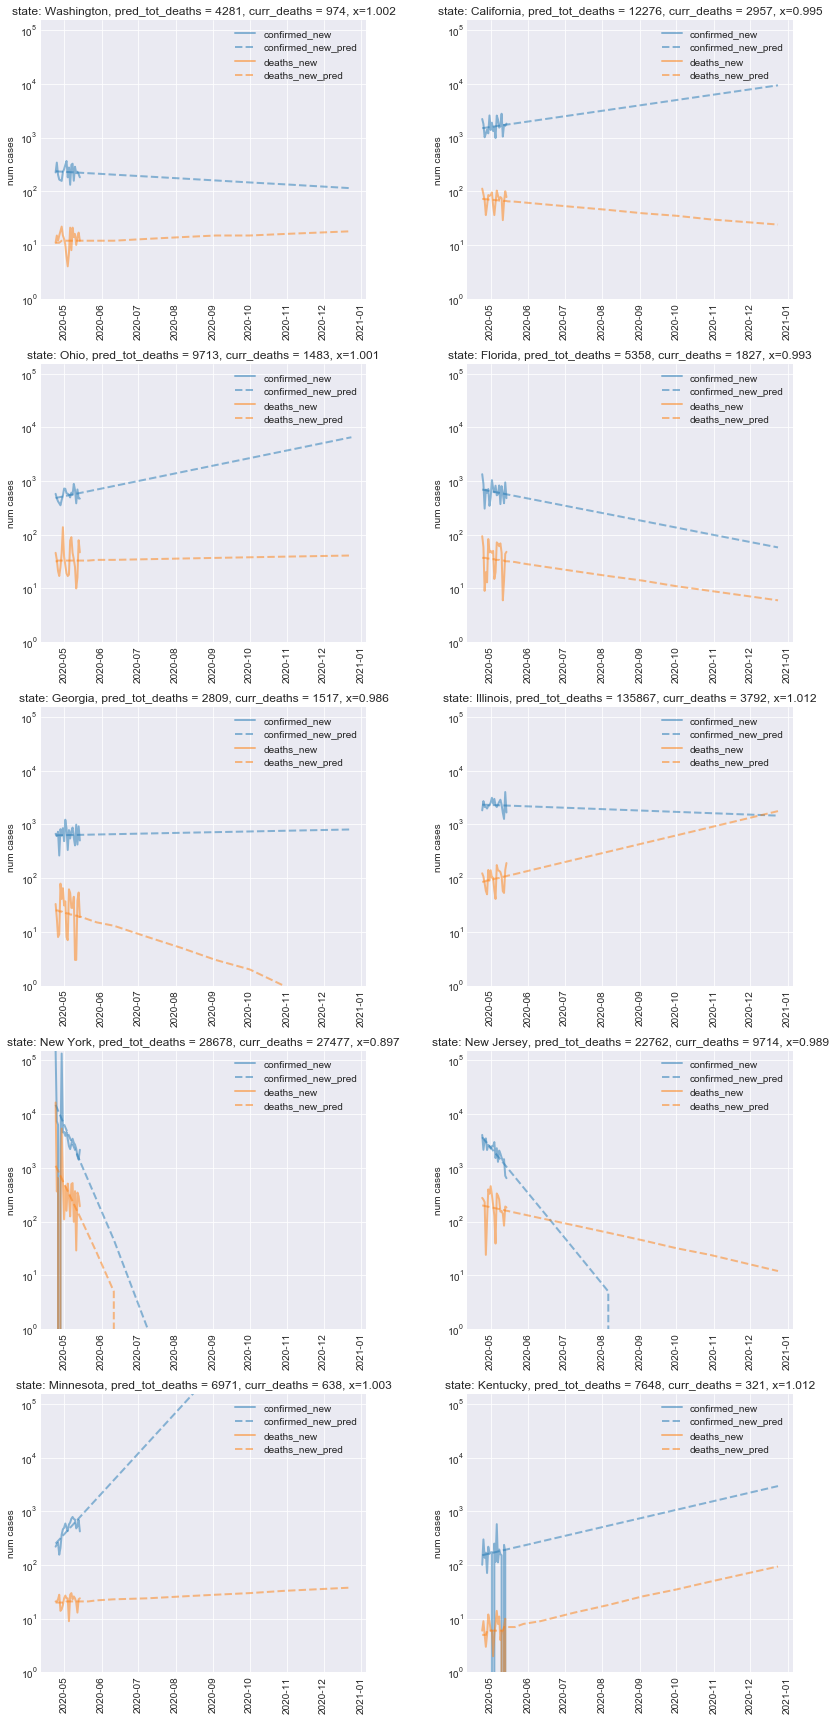

In [463]:
plot_forecasts_new(dfp_us_recent_1, col_locale='state', top_countries=['Washington', 'California', 'Ohio', 'Florida', 'Georgia', 'Illinois', 'New York', 'New Jersey', 'Minnesota', 'Kentucky'])

In [464]:
save_forecast_new(dfp_forecasts_us_out_1, dfp_us_recent_1, 'state', n_days_training=n_days_training)

saved forecast to predictions/new_cases_covid-19_state_forecast_from_2020-05-14_n_days_training=21.csv


### Which states are increasing in new deaths <u>most</u> quickly?

In [465]:
dfp_us_frac_new_increase = (dfp_us_recent_1[['state', 'frac_increase_deaths', 'frac_increase_confirmed']].
                             drop_duplicates().
                             sort_values(by='frac_increase_deaths', ascending=0).
                             reset_index(drop=True)
                            )
dfp_us_frac_new_increase.head(10)

state  frac_increase_deaths  frac_increase_confirmed
0           Iowa              0.031928                -0.003633
1    Mississippi              0.031071                -0.008985
2   Pennsylvania              0.028126                -0.030687
3        Arizona              0.027090                 0.017961
4  New Hampshire              0.025935                 0.003778
5       Missouri              0.018943                -0.022817
6        Alabama              0.018096                 0.017071
7      Tennessee              0.017985                -0.021993
8     New Mexico              0.014192                 0.004788
9       Illinois              0.012493                -0.001929

### Which states are increasing in new deaths <u>least</u> quickly?

In [466]:
dfp_us_frac_new_increase.tail(10)

state  frac_increase_deaths  frac_increase_confirmed
48       Nebraska             -0.013411                -0.015453
49        Georgia             -0.014089                 0.001032
50       Colorado             -0.023502                -0.032848
51  Massachusetts             -0.026839                -0.053391
52    Puerto Rico             -0.028225                -0.008956
53      Louisiana             -0.029039                -0.011174
54       Oklahoma             -0.033863                -0.000724
55    Connecticut             -0.033946                -0.019153
56       Michigan             -0.054136                -0.047289
57       New York             -0.103208                -0.113352

### Is there a day-of-the-week effect on new deaths?

In [467]:
dfp_us_recent_1['dow'] = dfp_us_recent_1['date'].apply(lambda x: x.weekday())
dfp_us_dow = dfp_us_recent_1.dropna(subset={'deaths_new'}).copy()

In [468]:
dfp_us_dow['death_delta'] = dfp_us_dow['deaths_new']- dfp_us_dow['deaths_new_pred']
dfp_us_dow['death_rel_delta'] = (dfp_us_dow['death_delta']) / dfp_us_dow['deaths_new_pred']

dfp_us_dow['confirmed_delta'] = dfp_us_dow['confirmed_new']- dfp_us_dow['confirmed_new_pred']
dfp_us_dow['confirmed_rel_delta'] = dfp_us_dow['confirmed_delta'] / dfp_us_dow['confirmed_new_pred']
dfp_us_dow_deltas = (dfp_us_dow.groupby(['state', 'dow'], as_index=False).
                     agg({'death_delta': np.mean, 
                          'death_rel_delta': np.median, 
                          'deaths_new': np.mean, 
                          'deaths_new_pred': np.mean, 
                          'confirmed_delta': np.mean, 
                          'confirmed_rel_delta': np.median})
                    )

In [469]:
dfp_us_dow_deltas[dfp_us_dow_deltas.state == 'Washington']

state  dow  death_delta  death_rel_delta  deaths_new  \
378  Washington    0    -2.000000        -0.166667    9.666667   
379  Washington    1    -1.500000        -0.125000   10.500000   
380  Washington    2     8.000000         0.750000   20.000000   
381  Washington    3    -0.333333         0.000000   11.666667   
382  Washington    4     3.333333         0.083333   15.000000   
383  Washington    5     1.333333         0.166667   13.000000   
384  Washington    6    -0.333333         0.090909   11.333333   

     deaths_new_pred  confirmed_delta  confirmed_rel_delta  
378        11.666667       -40.333333            -0.201754  
379        12.000000        28.500000             0.125393  
380        12.000000       -61.666667            -0.327586  
381        12.000000        14.000000            -0.012987  
382        11.666667        38.666667             0.117391  
383        11.666667        39.666667             0.347826  
384        11.666667        55.666667             0.276786

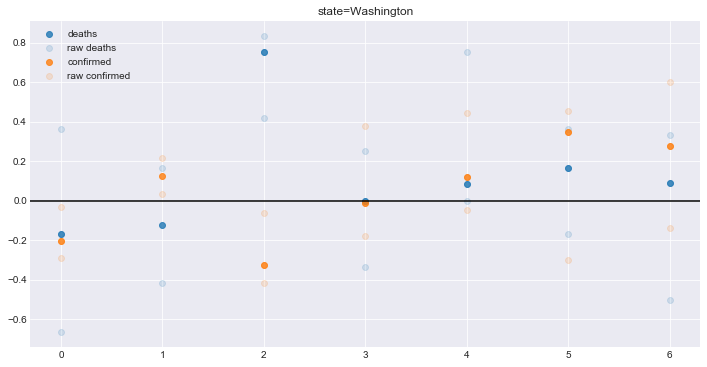

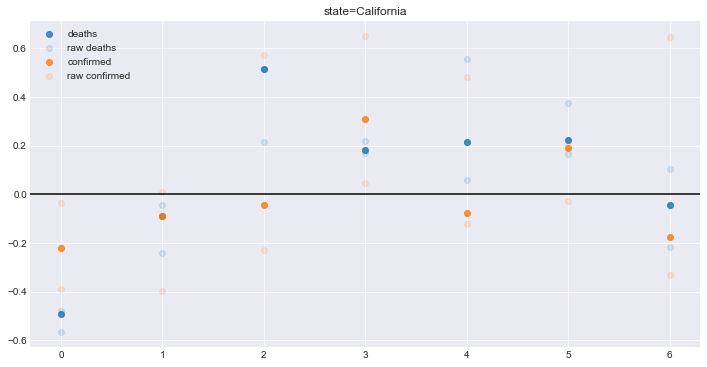

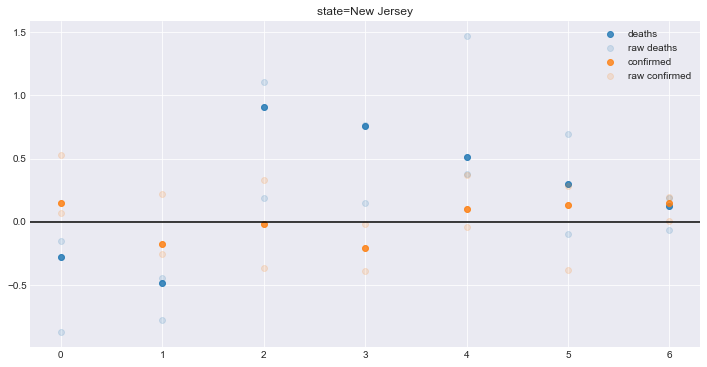

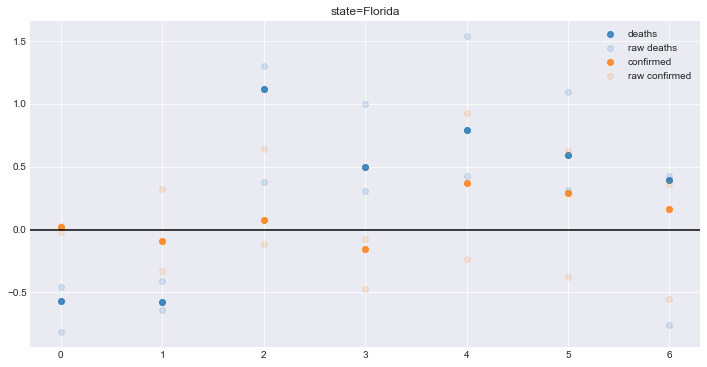

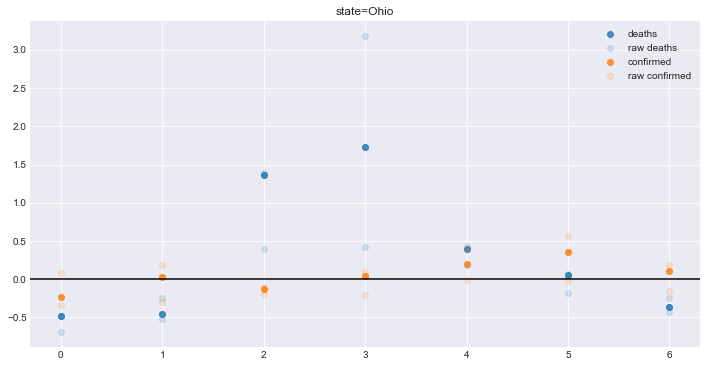

In [470]:
alpha_soft = 0.15
alpha_hard = 0.8
for state in ['Washington', 'California', 'New Jersey', 'Florida', 'Ohio']:
    dfp_plot = dfp_us_dow_deltas[(dfp_us_dow_deltas.state == state)]  #(dfp_us_dow_deltas.deaths_new >= 10) & 
    dfp_plot_raw = dfp_us_dow[dfp_us_dow.state == state]
    
    p = plt.plot(dfp_plot['dow'], dfp_plot['death_rel_delta'], 'o', alpha=alpha_hard, label='deaths')
    color = p[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['death_rel_delta'], 'o', alpha=alpha_soft, label='raw deaths', color=color)
    
    q = plt.plot(dfp_plot['dow'], dfp_plot['confirmed_rel_delta'], 'o', alpha=alpha_hard, label='confirmed')
    color = q[0].get_color()
    plt.plot(dfp_plot_raw['dow'], dfp_plot_raw['confirmed_rel_delta'], 'o', alpha=alpha_soft, label='raw confirmed', color=color)
    
    plt.legend(loc='best')
    plt.axhline(0, color='k')
    plt.title(f'state={state}')

    #plt.ylim([-0.5,0.5])
    #plt.ylim([-2,2])
    plt.show()